In [4]:
from pathlib import Path
import sys
sys.path.insert(0, "../")
from ukbfound.tokenizer.trait_tokenizer import ValueVocab
from ukbfound.model import TransformerModel
import pandas as pd
import json
import ukbfound
logger = ukbfound.logger
import torch
import numpy as np
from torch import nn


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


In [27]:
data_dir = Path("../data/UKB")
data_df = pd.read_csv(data_dir / "output_data.csv", index_col=0)

In [6]:

from anndata import AnnData
import scanpy as sc
from scanpy.get import _get_obs_rep, _set_obs_rep
import shutil
from scipy.sparse import issparse
from sklearn.model_selection import train_test_split
from ukbfound.tokenizer import tokenize_and_pad_batch, random_mask_value
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple, Dict, Union, Optional
import os

#model_dir = Path("save/all_data_dev_UKB-Jul11-17-11")
# 加载模型和词库
model_dir = Path("save/dev_UKB-Sep10-00-11") #dev_UKB-Sep10-00-11 dev_UKB-Aug20-22-27 dev_UKB-Aug07-18-18 只提取20002，随机15%20002疾病 mask训练；  dev_UKB-Aug08-21-38 随机15%20002疾病 mask训练；  dev_UKB-Aug11-22-41 随机5%mask训练； dev_UKB-Aug20-22-27
model_config_file = model_dir / "config.json"
model_file = model_dir / "model.pt"
vocab_file = model_dir / "vocab.json"

pad_token = "<pad>"
mask_token = "<mask>"
cls_token = "<cls>"
vocab = ValueVocab.from_file(vocab_file)



traits_df = pd.read_csv(data_dir / 'ukb_traits.csv', encoding='latin1', quotechar='"')
# 创建一个字典，其中 token_id 是键，token_id 是值
token_dict = dict(zip(traits_df['token_id'], traits_df['token_id']))
#  vacab need start with 0 index
token_dict['<cls>'] = 0  # 和其他模式统一， 用0
token_dict['<mask>'] = len(token_dict)
token_dict['<pad>'] = len(token_dict)

# 将values字典保存成 JSON 文件
with open(data_dir / "vocab.json", 'w') as f:
    json.dump(token_dict, f, indent=4)

vocab_file = data_dir / "vocab.json"
vocab = ValueVocab.from_file(vocab_file)
shutil.copy(vocab_file, "values_vocab.json")
vocab.set_default_index(vocab["<pad>"])
# change adata value to combine 'col_value' style
d20002_data_df = data_df.loc[:, data_df.columns.str.contains('d20002')]  ########## 在一开始就定义了只获取d20002的信息
d20002_data_df = d20002_data_df.fillna(vocab["<pad>"])
adata = sc.AnnData(d20002_data_df.values)

trait_dict = {v:i for i, v in  enumerate(traits_df['trait'].unique(), 1)}

value2trait_dict = {}
for value_id in traits_df['token_id']:
    value2trait_dict[value_id] = trait_dict[traits_df.loc[traits_df['token_id'] == value_id, 'trait'].iat[0]]
value2trait_dict.update({token_dict['<cls>']:0})
value2trait_dict.update({token_dict['<mask>']:max(value2trait_dict.values())+1})
value2trait_dict.update({token_dict['<pad>']:max(value2trait_dict.values())+1})
# 创建一个向量化的函数，用于字典查找
vectorized_replace = np.vectorize(value2trait_dict.get)

# 获取特殊字符value
mask_value = vocab[mask_token]
pad_value = vocab[pad_token]
cls_value = vocab[cls_token]

# 使用该函数对 all_counts 进行替换，并覆盖原数组
trait_ids = vectorized_replace(adata.X)


input_layer_key = None

individualtypes_labels = np.array(range(adata.shape[0]))

train_data = adata.X

max_seq_len = 3000
mask_ratio = 0.15
tokenized_train = tokenize_and_pad_batch(
    train_data,
    trait_ids,
    max_len=max_seq_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=False,  # append <cls> token at the beginning
    include_zero_trait=True,
)

logger.info(
    f"train set number of samples: {tokenized_train['traits'].shape[0]}, "
    f"\n\t feature length: {tokenized_train['traits'].shape[1]}"
)


input_trait_ids_train = tokenized_train["traits"]
input_values_train = tokenized_train["values"]
target_values_train = tokenized_train["values"]
tensor_batch_labels_train = torch.zeros(input_trait_ids_train.shape[0])
tensor_individualtype_labels_train = tensor_batch_labels_train


train_data_pt = {
    "trait_ids": input_trait_ids_train,
    "values": input_values_train,
    "target_values": target_values_train,
    "batch_labels": tensor_batch_labels_train,
    "individualtype_labels": tensor_individualtype_labels_train,
}

# dataset
class SeqDataset(Dataset):
    def __init__(self, data: Dict[str, torch.Tensor]):
        self.data = data

    def __len__(self):
        return self.data["trait_ids"].shape[0]

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}


num_workers = len(os.sched_getaffinity(0))

dataset = SeqDataset(train_data_pt)


train_loader = DataLoader(
    dataset=dataset,
    batch_size=100,
    shuffle=True,
    drop_last=False,
    num_workers=num_workers,
    pin_memory=True,
)





# model
with open(model_config_file, "r") as f:
    model_configs = json.load(f)
logger.info(
    f"Resume model from {model_file}, the model args will override the "
    f"config {model_config_file}."
)
embsize = model_configs["layer_size"]
nhead = model_configs["nhead"]
d_hid = model_configs["layer_size"]
nlayers = model_configs["nlayers"]


dropout = model_configs["dropout"]
mask_value = vocab[mask_token]
pad_value = vocab[pad_token]
cls_value = vocab[cls_token]
MVC = False
DAB = False  # Domain adaptation by reverse backpropagation, set to 2 for separate optimizer
INPUT_BATCH_LABELS = False  # TODO: have these help MLM and MVC, while not to classifier

num_batch_types = 1
DSBN = False,  # Domain-spec batchnorm
input_emb_style = "combine"  # "category" or "continuous" or "scaling" or "combine"
n_input_bins = None
individual_emb_style = "avg-pool"  # "avg-pool" or "w-pool" or "cls"
mvc_decoder_style = "inner product"

ecs_threshold = model_configs["ecs_thres"]
explicit_zero_prob = True
fast_transformer = True
fast_transformer_backend = "flash"
pre_norm=False
CLS = False

ntokens = len(set(value2trait_dict.values()))  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    nlayers_cls=3,
    n_cls=num_types if CLS else 1,
    vocab=vocab,
    dropout=dropout,
    pad_token=pad_token,
    do_mvc=MVC,
    do_dab=DAB,
    use_batch_labels=INPUT_BATCH_LABELS,
    num_batch_labels=num_batch_types,
    domain_spec_batchnorm=DSBN,
    input_emb_style=input_emb_style,
    n_input_bins=n_input_bins,
    individual_emb_style=individual_emb_style,
    mvc_decoder_style=mvc_decoder_style,
    ecs_threshold=ecs_threshold,
    explicit_zero_prob=explicit_zero_prob,
    use_fast_transformer=fast_transformer,
    fast_transformer_backend=fast_transformer_backend,
    pre_norm=pre_norm,
)

# 加载模型参数
state_dict = torch.load(model_file)

# 去除所有键的 module. 前缀
new_state_dict = {}
for key, value in state_dict.items():
    if key.startswith('module.'):
        new_key = key[len('module.'):]  # 去除 module. 前缀
    else:
        new_key = key
    new_state_dict[new_key] = value

# 使用新的 state_dict 加载模型
model.load_state_dict(new_state_dict)

logger.info(f"Loading all model params from {model_file}")
model.eval()



for batch, batch_data in enumerate(train_loader):
    input_trait_ids = batch_data["trait_ids"].to('cpu')
    input_values = batch_data["values"].to('cpu')
    target_values = batch_data["target_values"].to('cpu')
    batch_labels = batch_data["batch_labels"].to('cpu')
    individualtype_labels = batch_data["individualtype_labels"].to('cpu')
    src_key_padding_mask = input_trait_ids.eq(vocab[pad_token])
    break

# 保存成文件
torch.save({
    'src_key_padding_mask': src_key_padding_mask,
    'input_trait_ids': input_trait_ids,
    'target_values': target_values,
    'input_values': input_values
}, 'tensor_data.pth')


"""
try:
    model.load_state_dict(torch.load(model_file))
    logger.info(f"Loading all model params from {model_file}")
    model.eval()
except:
    # only load params that are in the model and match the size
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_file)
    pretrained_dict = {
        k: v
        for k, v in pretrained_dict.items()
        if k in model_dict and v.shape == model_dict[k].shape
    }
    for k, v in pretrained_dict.items():
        logger.info(f"Loading params {k} with shape {v.shape}")
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
"""


/tmp/ipykernel_744466/4251054301.py:26: DtypeWarning: Columns (6,21,38) have mixed types. Specify dtype option on import or set low_memory=False.
  traits_df = pd.read_csv(data_dir / 'ukb_traits.csv', encoding='latin1', quotechar='"')


scGPT - INFO - train set number of samples: 502507, 
	 feature length: 445
scGPT - INFO - Resume model from save/dev_UKB-Sep10-00-11/model.pt, the model args will override the config save/dev_UKB-Sep10-00-11/config.json.


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


scGPT - INFO - Loading all model params from save/dev_UKB-Sep10-00-11/model.pt


'\ntry:\n    model.load_state_dict(torch.load(model_file))\n    logger.info(f"Loading all model params from {model_file}")\n    model.eval()\nexcept:\n    # only load params that are in the model and match the size\n    model_dict = model.state_dict()\n    pretrained_dict = torch.load(model_file)\n    pretrained_dict = {\n        k: v\n        for k, v in pretrained_dict.items()\n        if k in model_dict and v.shape == model_dict[k].shape\n    }\n    for k, v in pretrained_dict.items():\n        logger.info(f"Loading params {k} with shape {v.shape}")\n    model_dict.update(pretrained_dict)\n    model.load_state_dict(model_dict)\n'

In [43]:
trait_ids.shape

(502507, 445)

In [7]:
# 生成标记颜色的字典
# 读取coding6.tsv文件
coding_df = pd.read_csv('coding6.tsv', sep='\t')


# 构建最终node_id的映射字典
def find_final_node_meaning(coding_value):
    current_coding = coding_value
    current_node_id = coding_df[coding_df['coding'] == current_coding].iloc[0]['node_id']
    while True:
        row = coding_df[coding_df['node_id'] == current_node_id].iloc[0]
        if row['selectable'] == 'N' and row['parent_id'] == 0:
        #if row['selectable'] == 'N':
            #'''
            return row['meaning']
            '''
            if row['node_id'] == 1071: #1071 cardio; 1072 respiratory; 0 all
                return row['meaning']
            else:
                return 'other'
            '''
        current_node_id = row['parent_id']
        
final_node_meanings = {row['coding']: find_final_node_meaning(row['coding']) for index, row in coding_df.iterrows()}


'''
important_desease_coding_values = [1112, 1111, 1065]
for k in important_desease_coding_values:
    final_node_meanings[k] = str(k)
'''    

'\nimportant_desease_coding_values = [1112, 1111, 1065]\nfor k in important_desease_coding_values:\n    final_node_meanings[k] = str(k)\n'

In [8]:
# 获取每种疾病经过模型的transformer部分更新后的embedding值。
# 每种疾病使用在其他疾病为正常情况下为条件特征。
# 计算模型前的字段embedding和经过模型后的字段embedding
device = 'cuda:2'
src_base = torch.tensor(vectorized_replace(range(1464, 2355, 2)), dtype=torch.long, device=device)
value_base = torch.tensor(range(1464, 2355, 2), dtype=torch.long, device=device)
src_key_padding_mask_base = torch.zeros(src_base.shape).bool().to(device)

batch_labels = torch.zeros(value_base.shape[0]).to(device)

model.to(device)

transformer_output = model._encode(
                    src_base, value_base, src_key_padding_mask_base, batch_labels=batch_labels
                )

select_disease_embeddings = transformer_output[(value_base>=1464) & (2354>=value_base)]
trait_embeddings = {v.item(): select_disease_embeddings[i].detach().to('cpu').numpy() for i, v in enumerate(value_base[(value_base>=1464) & (2354>=value_base)])}
%timeit

In [35]:
# 20250126计算各个疾病大类间的相关性的cosine值和p value permutation
trait_embeddings_sub_dict = trait_embeddings

# 根据最终的疾病系统名字，把相关的疾病embedding堆叠起来
meaning_embedding_dict = {}
for token_id, emb in filtered_embeddings.items():
    value = traits_df.loc[traits_df['token_id'] == token_id, 'value'].iat[0]
    meaning = final_node_meanings.get(int(value), 'Unknown')
    if meaning not in meaning_embedding_dict:
        meaning_embedding_dict[meaning] = emb[selected_columns]
    else:
        meaning_embedding_dict[meaning] = np.vstack((meaning_embedding_dict[meaning] , emb[selected_columns]))
disease_system_embedding_dict = {}
# 计算各大系统疾病的均值embedding
for k, v in meaning_embedding_dict.items():
    disease_system_embedding_dict[k] = v.mean(axis=0)

# Perform pairwise cosine similarity calculation and permutation test
for disease_sys1, embedding_1 in disease_system_embedding_dict.items():
    for disease_sys2, embedding_2 in disease_system_embedding_dict.items():
        
        # Skip redundant calculation (e.g., system_1 vs system_2 is the same as system_2 vs system_1)
        if disease_sys1 >= disease_sys2:
            continue

        # Convert embeddings to 2D arrays as required by cosine_similarity
        system_1 = np.array([embedding_1])  # Shape: (1, n)
        system_2 = np.array([embedding_2])  # Shape: (1, n)
        
        # Calculate observed cosine similarity
        observed_similarity = cosine_similarity(system_1, system_2)[0][0]  # Getting the scalar value

        # Perform permutation test
        n_permutations = 10000
        perm_similarities = []
        for _ in range(n_permutations):
            # Randomly shuffle the embeddings of system_2
            permuted_system_2 = np.random.permutation(system_2.flatten())  # Flatten to ensure proper reshaping
            perm_similarity = cosine_similarity(system_1, permuted_system_2.reshape(1, -1))[0][0]
            perm_similarities.append(perm_similarity)
        
        # Calculate p-value: fraction of permuted similarities greater than or equal to the observed similarity
        p_value = np.mean(np.array(perm_similarities) >= observed_similarity)
        
        # Output results
        print(f"{disease_sys1}_{disease_sys2}    Observed Similarity: {observed_similarity}")
        print(f"{disease_sys1}_{disease_sys2}    P-value: {p_value}")

show_time()

cardiovascular_respiratory/ent    Observed Similarity: 0.8778688907623291
cardiovascular_respiratory/ent    P-value: 0.0016
cardiovascular_gastrointestinal/abdominal    Observed Similarity: 0.8757262229919434
cardiovascular_gastrointestinal/abdominal    P-value: 0.0024
cardiovascular_renal/urology    Observed Similarity: 0.924635112285614
cardiovascular_renal/urology    P-value: 0.0
cardiovascular_endocrine/diabetes    Observed Similarity: 0.8503893613815308
cardiovascular_endocrine/diabetes    P-value: 0.0188
cardiovascular_neurology/eye/psychiatry    Observed Similarity: 0.8853896856307983
cardiovascular_neurology/eye/psychiatry    P-value: 0.0027
cardiovascular_musculoskeletal/trauma    Observed Similarity: 0.8781227469444275
cardiovascular_musculoskeletal/trauma    P-value: 0.0006
cardiovascular_haematology/dermatology    Observed Similarity: 0.8833977580070496
cardiovascular_haematology/dermatology    P-value: 0.0001
cardiovascular_gynaecology/breast    Observed Similarity: 0.8455

/tmp/ipykernel_744466/2835906939.py:14: DtypeWarning: Columns (6,21,38) have mixed types. Specify dtype option on import or set low_memory=False.
  traits_df = pd.read_csv(data_dir / 'ukb_traits.ICD10.csv', encoding='latin1', quotechar='"')


共有的疾病有 205 个
Final plot_df:
                                  Paper  Common
Category                                       
cardiovascular                      126     249
respiratory/ent                     147     124
gastrointestinal/abdominal          256     244
renal/urology                       108      89
endocrine/diabetes                  125     167
neurology/eye/psychiatry            112     147
musculoskeletal/trauma              176     178
haematology/dermatology              99      83
gynaecology/breast                   72      26
immunological/systemic disorders     82     101
infections                           45      52


<Figure size 1000x600 with 0 Axes>

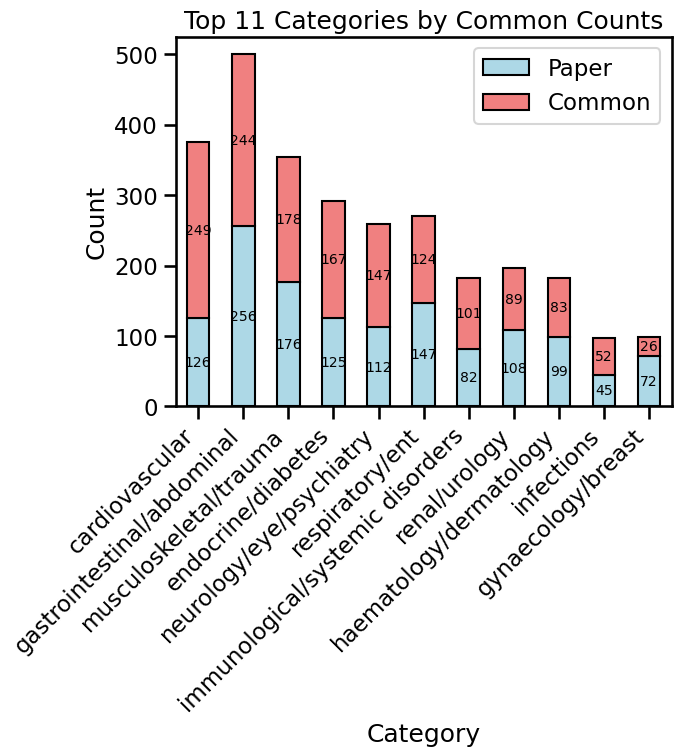

In [377]:
# 重要 20250404 paper1 算和文章对比的柱状图 用已知cosine 过滤错误数据
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# 读取数据文件
file_path_similarity = 'APP2.comorbid_pairs.csv'  # APP2.all_diseases_similarity.ICD10.csv
file_path_multimorbidities = 'APP2.paper_multimorbidities.ICD10.csv'

# 加载 CSV 文件
similarity_df = pd.read_csv(file_path_similarity, index_col=0)
multimorbidities_df = pd.read_csv(file_path_multimorbidities)
traits_df = pd.read_csv(data_dir / 'ukb_traits.ICD10.csv', encoding='latin1', quotechar='"')
traits_dict = traits_df[traits_df['field_id'] == 20002].set_index('ICD10')['value_category'].to_dict()
icd_dict = traits_df[traits_df['field_id'] == 20002].set_index('meaning')['ICD10'].to_dict()
# 拆分并处理 Disease2 列，创建共病组合的 DataFrame
def process_disease_combinations(df):
    expanded_rows = []
    for _, row in df.iterrows():
        disease1 = row['Disease1']
        disease2_list = row['Disease2'].split(';')  # 拆分 Disease2
        category1 = row['Category1']
        category2 = row['Category2']
        for disease2 in disease2_list:
            expanded_rows.append({
                'Disease1': disease1,
                'Disease2': disease2.strip(),
                'RR': row['RR'],
                'Category1': category1,
                'Category2': category2
            })
    return pd.DataFrame(expanded_rows)

# 处理 multimorbidities 数据
processed_multimorbidities_df = process_disease_combinations(multimorbidities_df)

# 初始化 plot_df，并设置 Paper 和 Common 列为 0
unique_categories = pd.Series(traits_df.loc[traits_df['field_id'] == 20002, 'value_category'].unique())
plot_df = pd.DataFrame({"Category": unique_categories, "Paper": 0, "Common": 0})
plot_df = plot_df.set_index('Category')

threshold = 0.36 # 290
# 检查处理结果
#print("Initial plot_df:")
#print(plot_df)

c = 0 
common_disease = []
# 查询两个地方共有的疾病有多少个 
paper_diseases = set(np.concatenate([processed_multimorbidities_df['Disease1'].values, processed_multimorbidities_df['Disease2'].values]))
our_diseases =  set([icd_dict.get(d, None)  for d in np.concatenate([similarity_df['Disease1'].values, similarity_df['Disease2'].values])])
common_diseases = [d for d in paper_diseases if d in our_diseases]
print(f'共有的疾病有 {len(common_diseases)} 个')


# 逐个迭代我们文章里面的共病对

similarity_df_stack = similarity_df

# 新增一列，保证Similarity和原来的Disease1, Disease2匹配
similarity_df_stack['Sorted'] = similarity_df_stack.apply(lambda x: tuple(sorted([x['Disease1'], x['Disease2']])), axis=1)

# 按排序后的Disease1, Disease2去重
similarity_df_stack = similarity_df_stack.drop_duplicates(subset=['Sorted']).drop(columns=['Sorted'])
all_multi_rows = []
for _, row in similarity_df_stack.iterrows():
    d1_name = row['Disease1']
    d2_name = row['Disease2']
    d1 = icd_dict.get(d1_name, None)
    d2 = icd_dict.get(d2_name, None)
    #print(row)
    similarity_value = float(row['Similarity'])
    if (d1 not in common_diseases) or (d2 not in common_diseases):
        continue
    category1 = traits_dict.get(d1, None)
    category2 = traits_dict.get(d2, None)
    # 我们是共病，用平均cosine判断
    if similarity_value <threshold:
        continue
    if d1 == d2:
        continue
    
    # 查找在文章中是否有这个共病对, 在两个位置分别判断
    p_df = processed_multimorbidities_df
    paper_row_df = p_df[(p_df['Disease1'] == d1) & (p_df['Disease2'] == d2)]
    if paper_row_df.empty:
        paper_row_df = p_df[(p_df['Disease1'] == d2) & (p_df['Disease2'] == d1)]
        if paper_row_df.empty:
            # 两次都不在，就是我们独有的
            plot_df.loc[category1, 'Paper'] += 1
            plot_df.loc[category2, 'Paper'] += 1
            all_multi_rows.append({
            'Category1': category1,
            'Category2': category2,
            'Disease1': d1,
            'Disease2': d2,
            'cosine': similarity_value,
            'type': 'only', 
            })
            continue
    '''
    if paper_row_df['RR'].iloc[0] < 2:
        # 阈值不过关也算
        plot_df.loc[category1, 'Paper'] += 1
        plot_df.loc[category2, 'Paper'] += 1
        all_multi_rows.append({
        'Category1': category1,
        'Category2': category2,
        'Disease1': d1,
        'Disease2': d2,
        'cosine': similarity_value,
        'type': 'only', 
        })
        continue
    '''
    plot_df.loc[category1, 'Common'] += 1
    plot_df.loc[category2, 'Common'] += 1
    all_multi_rows.append({
            'Category1': category1,
            'Category2': category2,
            'Disease1': d1,
            'Disease2': d2,
            'cosine': similarity_value,
            'type': 'common', 
        })
    
all_multimorbidities_df = pd.DataFrame(all_multi_rows)
all_multimorbidities_df.to_csv('APP2.paper1.all_multimorbidities.csv')


# 检查最终 plot_df 结果
print("Final plot_df:")
print(plot_df)


# 1. Save plot_df to 'APP2.paper1_hist_plot.csv'
plot_df.to_csv('APP2.paper1_hist_plot.csv')

# 2. Read the saved CSV and plot a stacked bar chart
plot_df_loaded = pd.read_csv('APP2.paper1_hist_plot.csv', index_col=0)

# Sort plot_df by the 'Common' column in descending order and select the top 10 categories
top_plot_df = plot_df.sort_values(by='Common', ascending=False).head(11)

# Plot the stacked bar chart for the top 10 categories
plt.figure(figsize=(10, 6))
top_plot_df[['Paper', 'Common']].plot(kind='bar', stacked=True, color=['lightblue', 'lightcoral'], edgecolor='black')

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Top 11 Categories by Common Counts')
plt.legend(['Paper', 'Common'])
plt.xticks(rotation=45, ha='right')

# Display the values on each bar
for i, (paper, common) in enumerate(zip(top_plot_df['Paper'], top_plot_df['Common'])):
    plt.text(i, paper / 2, f'{int(paper)}', ha='center', va='center', color='black', fontsize=10)
    plt.text(i, paper + common / 2, f'{int(common)}', ha='center', va='center', color='black', fontsize=10)

# Show and save the plot
#plt.tight_layout()
plt.savefig('APP2.paper1_hist_plot.svg', dpi=300, bbox_inches='tight')
plt.show()



/tmp/ipykernel_744466/333754539.py:14: DtypeWarning: Columns (6,21,38) have mixed types. Specify dtype option on import or set low_memory=False.
  traits_df = pd.read_csv(data_dir / 'ukb_traits.ICD10.csv', encoding='latin1', quotechar='"')


共有的疾病有 212 个
Final plot_df:
                                  Paper  Common
Category                                       
cardiovascular                      197     151
respiratory/ent                     119      64
gastrointestinal/abdominal          191     124
renal/urology                       117      64
endocrine/diabetes                  147      98
neurology/eye/psychiatry            273      96
musculoskeletal/trauma              144     105
haematology/dermatology              88      40
gynaecology/breast                   52       3
immunological/systemic disorders    128      87
infections                           72      30


<Figure size 640x480 with 0 Axes>

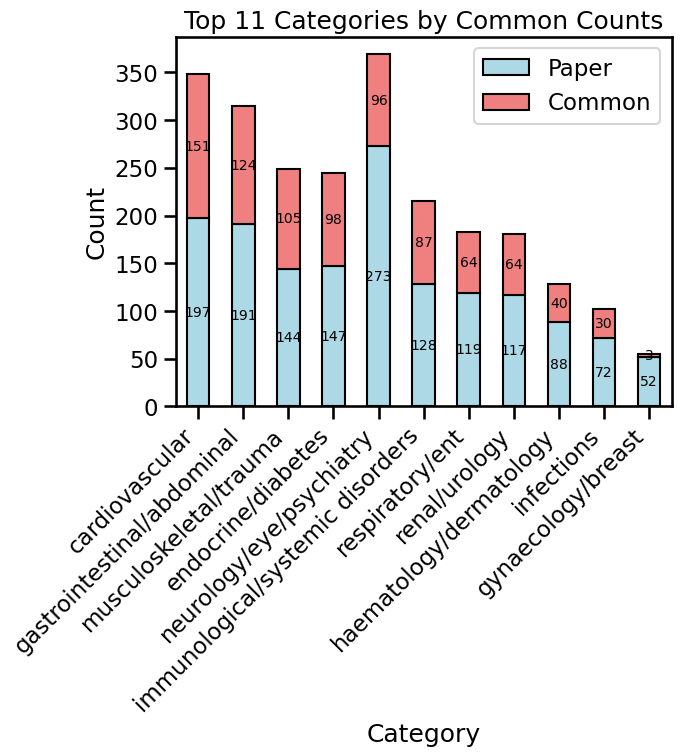

In [378]:
# 重要  20250404 paper2 算和文章对比的柱状图 用已知cosine 过滤错误数据
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# 读取数据文件
file_path_similarity = 'APP2.comorbid_pairs.csv'  # APP2.all_diseases_similarity.ICD10.csv
file_path_multimorbidities = 'paper2_multimorbidity.xlsx'

# 加载 CSV 文件
similarity_df = pd.read_csv(file_path_similarity, index_col=0)
multimorbidities_df = pd.read_excel(file_path_multimorbidities)
traits_df = pd.read_csv(data_dir / 'ukb_traits.ICD10.csv', encoding='latin1', quotechar='"')
traits_dict = traits_df[traits_df['field_id'] == 20002].set_index('ICD10')['value_category'].to_dict()
icd_dict = traits_df[traits_df['field_id'] == 20002].set_index('meaning')['ICD10'].to_dict()

# 拆分并处理 Disease2 列，创建共病组合的 DataFrame
def process_disease_combinations(df):
    expanded_rows = []
    for _, row in df.iterrows():
        disease1 = row['Disease1']
        disease2_list = row['Disease2'].split(';')  # 拆分 Disease2
        category1 = row['Category1']
        category2 = row['Category2']
        for disease2 in disease2_list:
            expanded_rows.append({
                'Disease1': disease1,
                'Disease2': disease2.strip(),
                'RR': row['RR'],
                'Category1': category1,
                'Category2': category2
            })
    return pd.DataFrame(expanded_rows)

# 处理 multimorbidities 数据
processed_multimorbidities_df = process_disease_combinations(multimorbidities_df)

# 初始化 plot_df，并设置 Paper 和 Common 列为 0
unique_categories = pd.Series(traits_df.loc[traits_df['field_id'] == 20002, 'value_category'].unique())
plot_df = pd.DataFrame({"Category": unique_categories, "Paper": 0, "Common": 0})
plot_df = plot_df.set_index('Category')

threshold = 0.36 # 290
# 检查处理结果
#print("Initial plot_df:")
#print(plot_df)

c = 0 
common_disease = []
# 查询两个地方共有的疾病有多少个 
paper_diseases = set(np.concatenate([processed_multimorbidities_df['Disease1'].values, processed_multimorbidities_df['Disease2'].values]))
our_diseases =  set([icd_dict.get(d, None)  for d in np.concatenate([similarity_df['Disease1'].values, similarity_df['Disease2'].values])])
common_diseases = [d for d in paper_diseases if d in our_diseases]
print(f'共有的疾病有 {len(common_diseases)} 个')


# 逐个迭代我们文章里面的共病对


similarity_df_stack = similarity_df

# 新增一列，保证Similarity和原来的Disease1, Disease2匹配
similarity_df_stack['Sorted'] = similarity_df_stack.apply(lambda x: tuple(sorted([x['Disease1'], x['Disease2']])), axis=1)

# 按排序后的Disease1, Disease2去重
similarity_df_stack = similarity_df_stack.drop_duplicates(subset=['Sorted']).drop(columns=['Sorted'])
all_multi_rows = []
for _, row in similarity_df_stack.iterrows():
    d1_name = row['Disease1']
    d2_name = row['Disease2']
    d1 = icd_dict.get(d1_name, None)
    d2 = icd_dict.get(d2_name, None)
    similarity_value = float(row['Similarity'])
    if (d1 not in common_diseases) or (d2 not in common_diseases):
        continue
    category1 = traits_dict.get(d1, None)
    category2 = traits_dict.get(d2, None)
    # 我们是共病，用平均cosine判断
    if similarity_value <threshold:
        continue
    if d1 == d2:
        continue
    
    # 查找在文章中是否有这个共病对, 在两个位置分别判断
    p_df = processed_multimorbidities_df
    paper_row_df = p_df[(p_df['Disease1'] == d1) & (p_df['Disease2'] == d2)]
    if paper_row_df.empty:
        paper_row_df = p_df[(p_df['Disease1'] == d2) & (p_df['Disease2'] == d1)]
        if paper_row_df.empty:
            # 两次都不在，就是我们独有的
            plot_df.loc[category1, 'Paper'] += 1
            plot_df.loc[category2, 'Paper'] += 1
            all_multi_rows.append({
            'Category1': category1,
            'Category2': category2,
            'Disease1': d1,
            'Disease2': d2,
            'cosine': similarity_value,
            'type': 'only', 
            })
            continue
    '''
    if paper_row_df['RR'].iloc[0] < 2:
        # 阈值不过关也算
        plot_df.loc[category1, 'Paper'] += 1
        plot_df.loc[category2, 'Paper'] += 1
        all_multi_rows.append({
        'Category1': category1,
        'Category2': category2,
        'Disease1': d1,
        'Disease2': d2,
        'cosine': similarity_value,
        'type': 'only', 
        })
        continue
    '''
    plot_df.loc[category1, 'Common'] += 1
    plot_df.loc[category2, 'Common'] += 1
    all_multi_rows.append({
            'Category1': category1,
            'Category2': category2,
            'Disease1': d1,
            'Disease2': d2,
            'cosine': similarity_value,
            'type': 'common', 
        })
    
all_multimorbidities_df = pd.DataFrame(all_multi_rows)
all_multimorbidities_df.to_csv('APP2.paper2.all_multimorbidities.csv')


# 检查最终 plot_df 结果
print("Final plot_df:")
print(plot_df)


# 1. Save plot_df to 'APP2.paper1_hist_plot.csv'
plot_df.to_csv('APP2.paper2_hist_plot.csv')

# 2. Read the saved CSV and plot a stacked bar chart
plot_df_loaded = pd.read_csv('APP2.paper2_hist_plot.csv', index_col=0)

# Sort plot_df by the 'Common' column in descending order and select the top 10 categories
top_plot_df = plot_df.sort_values(by='Common', ascending=False).head(11)

# Plot the stacked bar chart for the top 10 categories
plt.figure()
top_plot_df[['Paper', 'Common']].plot(kind='bar', stacked=True, color=['lightblue', 'lightcoral'], edgecolor='black')

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Top 11 Categories by Common Counts')
plt.legend(['Paper', 'Common'])
plt.xticks(rotation=45, ha='right')

# Display the values on each bar
for i, (paper, common) in enumerate(zip(top_plot_df['Paper'], top_plot_df['Common'])):
    plt.text(i, paper / 2, f'{int(paper)}', ha='center', va='center', color='black', fontsize=10)
    plt.text(i, paper + common / 2, f'{int(common)}', ha='center', va='center', color='black', fontsize=10)

# Show and save the plot
#plt.tight_layout()
plt.savefig('APP2.paper2_hist_plot.svg', dpi=300, bbox_inches='tight')
plt.show()



/tmp/ipykernel_744466/2548573109.py:20: DtypeWarning: Columns (6,21,38) have mixed types. Specify dtype option on import or set low_memory=False.
  traits_df = pd.read_csv(data_dir / 'ukb_traits.ICD10.csv', encoding='latin1', quotechar='"')


共有的疾病有 13 个
Final plot_df:
                                  Paper  Common
Category                                       
cardiovascular                        2       4
respiratory/ent                       0       0
gastrointestinal/abdominal            0       3
renal/urology                         0       5
endocrine/diabetes                    4       2
neurology/eye/psychiatry              0       2
musculoskeletal/trauma                0       0
haematology/dermatology               8      20
gynaecology/breast                    0       0
immunological/systemic disorders      4       6
infections                            0       0


<Figure size 640x480 with 0 Axes>

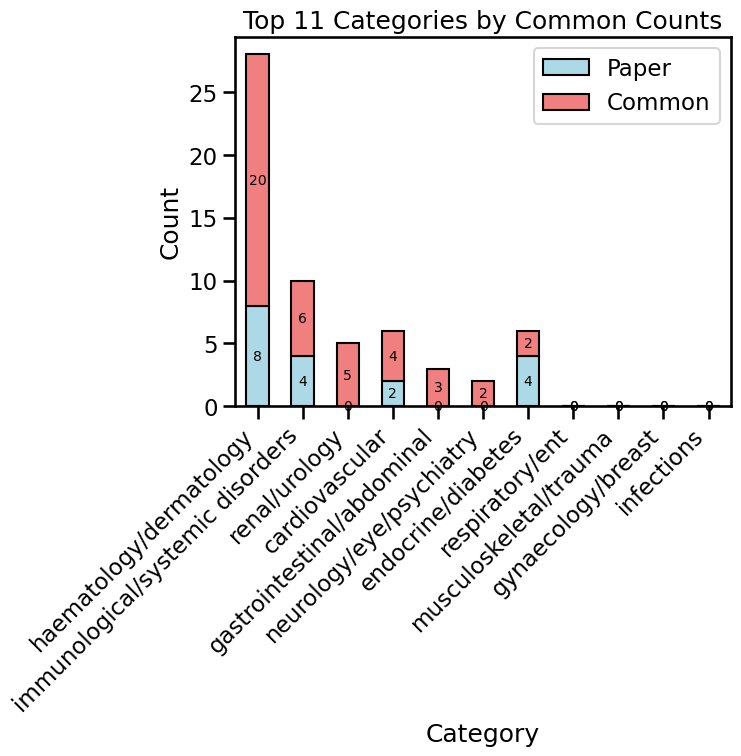

In [379]:
# 重要 20250404 paper3 算和文章对比的柱状图， 卡novel的阈值
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
# 20250404 paper2 算和文章对比的柱状图 用已知cosine 过滤错误数据
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency


# 读取数据文件
file_path_similarity = 'APP2.comorbid_pairs.csv'  # APP2.all_diseases_similarity.ICD10.csv
file_path_multimorbidities = 'paper3_multimorbidity.csv'

# 加载 CSV 文件
similarity_df = pd.read_csv(file_path_similarity, index_col=0)
multimorbidities_df = pd.read_csv(file_path_multimorbidities)
traits_df = pd.read_csv(data_dir / 'ukb_traits.ICD10.csv', encoding='latin1', quotechar='"')
traits_dict = traits_df[traits_df['field_id'] == 20002].set_index('ICD10')['value_category'].to_dict()
icd_dict = traits_df[traits_df['field_id'] == 20002].set_index('meaning')['ICD10'].to_dict()

# 拆分并处理 Disease2 列，创建共病组合的 DataFrame
def process_disease_combinations(df):
    expanded_rows = []
    for _, row in df.iterrows():
        if row.isnull().any():  # 检查是否有 NaN 或 None
            #print("Row contains None/NaN:", row)
            continue
        disease1_list = row['Disease1'].split(',') 
        disease2_list = row['Disease2'].split(',')  # 拆分 Disease2
        #category1 = row['Category1']
        #category2 = row['Category2']
        for disease1 in disease1_list: 
            for disease2 in disease2_list:
                expanded_rows.append({
                    'Disease1': disease1[:3],
                    'Disease2': disease2[:3],
                    #'RR': row['RR'],
                    #'Category1': category1,
                    #'Category2': category2
                })
    return pd.DataFrame(expanded_rows)

# 处理 multimorbidities 数据
processed_multimorbidities_df = process_disease_combinations(multimorbidities_df)

# 初始化 plot_df，并设置 Paper 和 Common 列为 0
unique_categories = pd.Series(traits_df.loc[traits_df['field_id'] == 20002, 'value_category'].unique())
plot_df = pd.DataFrame({"Category": unique_categories, "Paper": 0, "Common": 0})
plot_df = plot_df.set_index('Category')

threshold = 0.36 # 290
# 检查处理结果
#print("Initial plot_df:")
#print(plot_df)

c = 0 
common_disease = []

# 查询两个地方共有的疾病有多少个 
paper_diseases = set(np.concatenate([processed_multimorbidities_df['Disease1'].values, processed_multimorbidities_df['Disease2'].values]))
our_diseases =  set([icd_dict.get(d, None)  for d in np.concatenate([similarity_df['Disease1'].values, similarity_df['Disease2'].values])])
common_diseases = [d for d in paper_diseases if d in our_diseases]
print(f'共有的疾病有 {len(common_diseases)} 个')


# 逐个迭代我们文章里面的共病对

similarity_df_stack = similarity_df

# 新增一列，保证Similarity和原来的Disease1, Disease2匹配
similarity_df_stack['Sorted'] = similarity_df_stack.apply(lambda x: tuple(sorted([x['Disease1'], x['Disease2']])), axis=1)

# 按排序后的Disease1, Disease2去重
similarity_df_stack = similarity_df_stack.drop_duplicates(subset=['Sorted']).drop(columns=['Sorted'])
all_multi_rows = []
for _, row in similarity_df_stack.iterrows():
    d1_name = row['Disease1']
    d2_name = row['Disease2']
    d1 = icd_dict.get(d1_name, None)
    d2 = icd_dict.get(d2_name, None)
    similarity_value = float(row['Similarity'])
    if (d1 not in common_diseases) or (d2 not in common_diseases):
        continue
    category1 = traits_dict.get(d1, None)
    category2 = traits_dict.get(d2, None)
    # 我们是共病，用平均cosine判断
    if similarity_value <threshold:
        continue
    if d1 == d2:
        continue
    
    # 查找在文章中是否有这个共病对, 在两个位置分别判断
    p_df = processed_multimorbidities_df
    paper_row_df = p_df[(p_df['Disease1'] == d1) & (p_df['Disease2'] == d2)]
    if paper_row_df.empty:
        paper_row_df = p_df[(p_df['Disease1'] == d2) & (p_df['Disease2'] == d1)]
        if paper_row_df.empty:
            # 两次都不在，就是我们独有的
            plot_df.loc[category1, 'Paper'] += 1
            plot_df.loc[category2, 'Paper'] += 1
            all_multi_rows.append({
            'Category1': category1,
            'Category2': category2,
            'Disease1': d1,
            'Disease2': d2,
            'cosine': similarity_value,
            'type': 'only', 
            })
            continue
    '''
    if paper_row_df['RR'].iloc[0] < 2:
        # 阈值不过关也算
        plot_df.loc[category1, 'Paper'] += 1
        plot_df.loc[category2, 'Paper'] += 1
        all_multi_rows.append({
        'Category1': category1,
        'Category2': category2,
        'Disease1': d1,
        'Disease2': d2,
        'cosine': similarity_value,
        'type': 'only', 
        })
        continue
    '''
    plot_df.loc[category1, 'Common'] += 1
    plot_df.loc[category2, 'Common'] += 1
    all_multi_rows.append({
            'Category1': category1,
            'Category2': category2,
            'Disease1': d1,
            'Disease2': d2,
            'cosine': similarity_value,
            'type': 'common', 
        })
    
all_multimorbidities_df = pd.DataFrame(all_multi_rows)
all_multimorbidities_df.to_csv('APP2.paper3.all_multimorbidities.csv')


# 检查最终 plot_df 结果
print("Final plot_df:")
print(plot_df)


# 1. Save plot_df to 'APP2.paper1_hist_plot.csv'
plot_df.to_csv('APP2.paper3_hist_plot.csv')

# 2. Read the saved CSV and plot a stacked bar chart
plot_df_loaded = pd.read_csv('APP2.paper3_hist_plot.csv', index_col=0)

# Sort plot_df by the 'Common' column in descending order and select the top 10 categories
top_plot_df = plot_df.sort_values(by='Common', ascending=False).head(11)

# Plot the stacked bar chart for the top 10 categories
plt.figure()
top_plot_df[['Paper', 'Common']].plot(kind='bar', stacked=True, color=['lightblue', 'lightcoral'], edgecolor='black')

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Top 11 Categories by Common Counts')
plt.legend(['Paper', 'Common'])
plt.xticks(rotation=45, ha='right')

# Display the values on each bar
for i, (paper, common) in enumerate(zip(top_plot_df['Paper'], top_plot_df['Common'])):
    plt.text(i, paper / 2, f'{int(paper)}', ha='center', va='center', color='black', fontsize=10)
    plt.text(i, paper + common / 2, f'{int(common)}', ha='center', va='center', color='black', fontsize=10)

# Show and save the plot
#plt.tight_layout()
plt.savefig('APP2.paper3_hist_plot.svg', dpi=300, bbox_inches='tight')
plt.show()



In [400]:
# part1 20250402 计算所有系统的社区分群-paper  保存结果，做补充表
import networkx as nx
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import leidenalg
import igraph as ig
import matplotlib.pyplot as plt
import matplotlib

# Prepare an empty list to store community data
community_data = []

for disease_system in np.unique(list(final_node_meanings.values())):
    #if disease_system != 'respiratory/ent':
    #   continue
    if disease_system == 'unclassifiable':
        continue
    print(f'Processing system: {disease_system}')
    # 计算疾病间的相似度（cosine相似度）
    disease_ids = list(trait_embeddings.keys())
    disease_ids = [token_id for token_id in disease_ids if
                   final_node_meanings.get(int(traits_df.loc[traits_df['token_id'] == token_id, 'value'].iat[0]), 'Unknown')
                   in [disease_system]]  # ['cardiovascular', 'respiratory/ent']
    print(f'There are {len(disease_ids)} disease in this system.')
    disease_ids = [disease for disease in disease_ids if disease in trait_embeddings.keys()]
    embeddings = np.array([trait_embeddings[disease] for disease in disease_ids if disease in trait_embeddings.keys()])
    similarity_matrix = cosine_similarity(embeddings)
    
    # 处理负权重
    similarity_matrix[similarity_matrix < 0] = 0
    
    # 构建图
    G = nx.Graph()
    for i, disease_id_1 in enumerate(disease_ids):
        for j, disease_id_2 in enumerate(disease_ids):
            if i != j:  # 避免自环
                similarity = round(similarity_matrix[i][j], 2)
                if similarity > 0.36:
                    G.add_edge(disease_id_1, disease_id_2, weight=similarity)
                    
    # 设置每个节点的 'name' 属性，确保转换到 igraph 后能保留
    for node in G.nodes():
        G.nodes[node]['name'] = node
    
    
    # 将 NetworkX 图转换为 igraph 图
    ig_graph = ig.Graph.from_networkx(G)
    
    # 使用 Leiden 方法进行社区检测
    partition = leidenalg.find_partition(
        ig_graph, 
        leidenalg.ModularityVertexPartition, 
        weights='weight', 
        max_comm_size=5,  # 控制每个社区的最大大小 5
        n_iterations=70,  # 增加迭代次数来细分社区 70
        seed=9 # 7 9 8
    )


    # 原始 community ID 分配结果
    old_membership = partition.membership
    
    # 统计每个社区的节点数量
    community_counts = Counter(old_membership)
    
    # 按数量降序排列并创建映射表
    sorted_communities = sorted(community_counts.items(), key=lambda x: x[1], reverse=True)
    id_mapping = {old_id: new_id for new_id, (old_id, _) in enumerate(sorted_communities)}  # 从0开始编号
    
    # 替换为新的编号
    new_membership = [id_mapping[old_id] for old_id in old_membership]
    
    # 覆盖原始的 membership
    partition._membership = new_membership  
    """ """


    # 绘制聚类结果
    plt.figure(figsize=(12, 12))
    
    # 按照社区分配颜色
    colors = [partition.membership[i] for i in range(len(ig_graph.vs))]

    # 使用matplotlib的colormap来将社区编号映射到颜色
    color_map = plt.cm.get_cmap('tab20', len(set(colors)))  # 'tab20'是一个适合显示多社区的colormap
    # 使用 matplotlib.colormaps.get_cmap 来获取 colormap（避免弃用警告）
    #color_map = matplotlib.colormaps.get_cmap('tab20', len(set(colors)))
    node_colors = [color_map(c) for c in colors]  # 将每个节点的颜色映射到对应的社区
    
    # 使用spring_layout来优化节点的分布
    pos = nx.spring_layout(G, k=1, iterations=30)  # 调整k值和迭代次数来优化布局
    node_size = 500  # 节点大小，增加节点的可见度
    
    # 绘制图，使用排序后的pos和node_colors
    nx.draw(G, 
            pos=pos, 
            with_labels=True, 
            node_size=node_size, 
            node_color=node_colors, 
            font_size=10, 
            font_weight='bold', 
            edge_color=node_colors, 
            alpha=0.7)
    
    # edge weight labels
    d = nx.get_edge_attributes(G, "weight")
    edge_labels = {k: d[k] for k in nx.get_edge_attributes(G, 'weight').keys()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=15)
    
    plt.title("Disease Clustering Using Leiden Community Detection")
    #plt.show()
    plt.close()
    
    # 输出每个社区的疾病ID
    community_dict = {}
    for i, disease_id in enumerate(disease_ids):
        try:
            community_id = partition.membership[i]
        except:
            continue
        if community_id not in community_dict:
            community_dict[community_id] = []
        community_dict[community_id].append(disease_id)
    '''
    # 通过 igraph 顶点的 'name' 属性获取正确的 disease id
    community_dict = {}
    for vertex, comm in zip(ig_graph.vs, partition.membership):
        disease_id = vertex["name"]
        community_dict.setdefault(comm, []).append(disease_id)
    '''
    # 输出每个社区的疾病列表
    print(f'Total {len(community_dict)} community in this system')
    for community_id, diseases in community_dict.items():
        systems = [final_node_meanings.get(int(traits_df.loc[traits_df['token_id'] == token_id, 'value'].iat[0]), 'Unknown') for token_id in diseases]  # 获取疾病属于的系统
        disease_names = [traits_df.loc[traits_df['token_id'] == token_id, 'token'].iat[0].split("_")[1] for token_id in diseases]
        

        '''
        print(f"Community {community_id}: {diseases}")
        print(disease_names)
        # Display the sorted result
        for value, count in zip(sorted_vsystem_alues, sorted_counts):
            print(f"{value}: {count}")
        '''
        print(f'systems:{systems}')
        print(disease_names)

        row = {
            'Community_ID': community_id,
            'Disease_Name': '; '.join(disease_names).replace('"', ''),
            'Disease_System': disease_system,
            'System': systems[0],
            'Count': len(disease_names)

        }
        print(row)
        community_data.append(row)
    
    print(f'Total {len(community_dict)} communities in this system')
    print('-' * 20)

# Create a DataFrame from the collected data
df = pd.DataFrame(community_data)

# Save the DataFrame to a CSV file
df.to_csv('disease_community_data.csv', index=False)

print('Data saved to disease_community_data.csv')


Processing system: cardiovascular
There are 50 disease in this system.


/tmp/ipykernel_744466/1672121500.py:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', len(set(colors)))  # 'tab20'是一个适合显示多社区的colormap


Total 11 community in this system
systems:['cardiovascular', 'cardiovascular', 'cardiovascular', 'cardiovascular', 'cardiovascular']
['"hypertension"', '"peripheral vascular disease"', '"heart arrhythmia"', '"cardiomyopathy"', '"aortic aneurysm"']
{'Community_ID': 0, 'Disease_Name': 'hypertension; peripheral vascular disease; heart arrhythmia; cardiomyopathy; aortic aneurysm', 'Disease_System': 'cardiovascular', 'System': 'cardiovascular', 'Count': 5}
systems:['cardiovascular', 'cardiovascular', 'cardiovascular', 'cardiovascular', 'cardiovascular']
['"heart/cardiac problem"', '"sick sinus syndrome"', '"aortic stenosis"', '"ischaemic stroke"', '"pericarditis"']
{'Community_ID': 1, 'Disease_Name': 'heart/cardiac problem; sick sinus syndrome; aortic stenosis; ischaemic stroke; pericarditis', 'Disease_System': 'cardiovascular', 'System': 'cardiovascular', 'Count': 5}
systems:['cardiovascular', 'cardiovascular', 'cardiovascular', 'cardiovascular', 'cardiovascular']
['"venous thromboembolic 

/tmp/ipykernel_744466/1672121500.py:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', len(set(colors)))  # 'tab20'是一个适合显示多社区的colormap


There are 61 disease in this system.


/tmp/ipykernel_744466/1672121500.py:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', len(set(colors)))  # 'tab20'是一个适合显示多社区的colormap


Total 13 community in this system
systems:['gastrointestinal/abdominal', 'gastrointestinal/abdominal', 'gastrointestinal/abdominal', 'gastrointestinal/abdominal', 'gastrointestinal/abdominal']
['"oesophageal disorder"', '"gastro-oesophageal reflux (gord) / gastric reflux"', '"oesophageal stricture"', '"infective/viral hepatitis"', '"inguinal hernia"']
{'Community_ID': 0, 'Disease_Name': 'oesophageal disorder; gastro-oesophageal reflux (gord) / gastric reflux; oesophageal stricture; infective/viral hepatitis; inguinal hernia', 'Disease_System': 'gastrointestinal/abdominal', 'System': 'gastrointestinal/abdominal', 'Count': 5}
systems:['gastrointestinal/abdominal', 'gastrointestinal/abdominal', 'gastrointestinal/abdominal', 'gastrointestinal/abdominal', 'gastrointestinal/abdominal']
['"stomach disorder"', '"oesophagitis/barretts oesophagus"', '"gastrointestinal bleeding"', '"hepatitis b"', '"constipation"']
{'Community_ID': 1, 'Disease_Name': 'stomach disorder; oesophagitis/barretts oesop

/tmp/ipykernel_744466/1672121500.py:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', len(set(colors)))  # 'tab20'是一个适合显示多社区的colormap
/tmp/ipykernel_744466/1672121500.py:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', len(set(colors)))  # 'tab20'是一个适合显示多社区的colormap


There are 31 disease in this system.
Total 6 community in this system
systems:['haematology/dermatology', 'haematology/dermatology', 'haematology/dermatology', 'haematology/dermatology', 'haematology/dermatology']
['"low platelets/platelet disorder"', '"iron deficiency anaemia"', '"thalassaemia"', '"myeloproliferative disorder"', '"chronic skin ulcers"']
{'Community_ID': 0, 'Disease_Name': 'low platelets/platelet disorder; iron deficiency anaemia; thalassaemia; myeloproliferative disorder; chronic skin ulcers', 'Disease_System': 'haematology/dermatology', 'System': 'haematology/dermatology', 'Count': 5}
systems:['haematology/dermatology', 'haematology/dermatology', 'haematology/dermatology', 'haematology/dermatology', 'haematology/dermatology']
['"haemophilia"', '"pemphigoid/pemphigus"', '"blistering/desquamating skin disorder"', '"lichen planus"', '"rosacea"']
{'Community_ID': 1, 'Disease_Name': 'haemophilia; pemphigoid/pemphigus; blistering/desquamating skin disorder; lichen planus; 

/tmp/ipykernel_744466/1672121500.py:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', len(set(colors)))  # 'tab20'是一个适合显示多社区的colormap
/tmp/ipykernel_744466/1672121500.py:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', len(set(colors)))  # 'tab20'是一个适合显示多社区的colormap


Total 6 community in this system
systems:['immunological/systemic disorders', 'immunological/systemic disorders', 'immunological/systemic disorders']
['"sarcoidosis"', '"polymyalgia rheumatica"', '"polyartertis nodosa"']
{'Community_ID': 5, 'Disease_Name': 'sarcoidosis; polymyalgia rheumatica; polyartertis nodosa', 'Disease_System': 'immunological/systemic disorders', 'System': 'immunological/systemic disorders', 'Count': 3}
systems:['immunological/systemic disorders', 'immunological/systemic disorders', 'immunological/systemic disorders', 'immunological/systemic disorders', 'immunological/systemic disorders']
['"vasculitis"', '"giant cell/temporal arteritis"', '"scleroderma/systemic sclerosis"', '"allergy or anaphylactic reaction to drug"', '"chronic fatigue syndrome"']
{'Community_ID': 0, 'Disease_Name': 'vasculitis; giant cell/temporal arteritis; scleroderma/systemic sclerosis; allergy or anaphylactic reaction to drug; chronic fatigue syndrome', 'Disease_System': 'immunological/syst

/tmp/ipykernel_744466/1672121500.py:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', len(set(colors)))  # 'tab20'是一个适合显示多社区的colormap


Total 14 community in this system
systems:['musculoskeletal/trauma', 'musculoskeletal/trauma', 'musculoskeletal/trauma', 'musculoskeletal/trauma']
['"bone disorder"', '"osteoporosis"', '"scoliosis"', '"fracture upper arm / humerus / elbow"']
{'Community_ID': 12, 'Disease_Name': 'bone disorder; osteoporosis; scoliosis; fracture upper arm / humerus / elbow', 'Disease_System': 'musculoskeletal/trauma', 'System': 'musculoskeletal/trauma', 'Count': 4}
systems:['musculoskeletal/trauma', 'musculoskeletal/trauma', 'musculoskeletal/trauma', 'musculoskeletal/trauma', 'musculoskeletal/trauma']
['"back problem"', '"plantar fascitis"', '"bursitis"', '"tennis elbow / lateral epicondylitis"', '"housemaid\'s knee (prepatellar bursitis)"']
{'Community_ID': 0, 'Disease_Name': "back problem; plantar fascitis; bursitis; tennis elbow / lateral epicondylitis; housemaid's knee (prepatellar bursitis)", 'Disease_System': 'musculoskeletal/trauma', 'System': 'musculoskeletal/trauma', 'Count': 5}
systems:['muscul

/tmp/ipykernel_744466/1672121500.py:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', len(set(colors)))  # 'tab20'是一个适合显示多社区的colormap


Total 14 community in this system
systems:['neurology/eye/psychiatry', 'neurology/eye/psychiatry', 'neurology/eye/psychiatry', 'neurology/eye/psychiatry', 'neurology/eye/psychiatry']
['"neurological injury/trauma"', '"infection of nervous system"', '"encephalitis"', '"parkinsons disease"', '"diabetic eye disease"']
{'Community_ID': 0, 'Disease_Name': 'neurological injury/trauma; infection of nervous system; encephalitis; parkinsons disease; diabetic eye disease', 'Disease_System': 'neurology/eye/psychiatry', 'System': 'neurology/eye/psychiatry', 'Count': 5}
systems:['neurology/eye/psychiatry', 'neurology/eye/psychiatry', 'neurology/eye/psychiatry', 'neurology/eye/psychiatry', 'neurology/eye/psychiatry']
['"eye/eyelid problem"', '"spinal cord disorder"', '"chronic/degenerative neurological problem"', '"mania/bipolar disorder/manic depression"', '"opioid dependency"']
{'Community_ID': 1, 'Disease_Name': 'eye/eyelid problem; spinal cord disorder; chronic/degenerative neurological problem;

/tmp/ipykernel_744466/1672121500.py:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', len(set(colors)))  # 'tab20'是一个适合显示多社区的colormap
/tmp/ipykernel_744466/1672121500.py:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', len(set(colors)))  # 'tab20'是一个适合显示多社区的colormap


There are 36 disease in this system.
Total 8 community in this system
systems:['respiratory/ent', 'respiratory/ent', 'respiratory/ent', 'respiratory/ent', 'respiratory/ent']
['"asthma"', '"emphysema/chronic bronchitis"', '"asbestosis"', '"fibrosing alveolitis/unspecified alveolitis"', '"pneumothorax"']
{'Community_ID': 0, 'Disease_Name': 'asthma; emphysema/chronic bronchitis; asbestosis; fibrosing alveolitis/unspecified alveolitis; pneumothorax', 'Disease_System': 'respiratory/ent', 'System': 'respiratory/ent', 'Count': 5}
systems:['respiratory/ent', 'respiratory/ent', 'respiratory/ent', 'respiratory/ent', 'respiratory/ent']
['"chronic obstructive airways disease/copd"', '"sleep apnoea"', '"pleurisy"', '"bronchitis"', '"nasal polyps"']
{'Community_ID': 1, 'Disease_Name': 'chronic obstructive airways disease/copd; sleep apnoea; pleurisy; bronchitis; nasal polyps', 'Disease_System': 'respiratory/ent', 'System': 'respiratory/ent', 'Count': 5}
systems:['respiratory/ent', 'respiratory/ent',

/tmp/ipykernel_744466/1270593735.py:69: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', len(set(colors)))  # 'tab20'是一个适合显示多社区的colormap


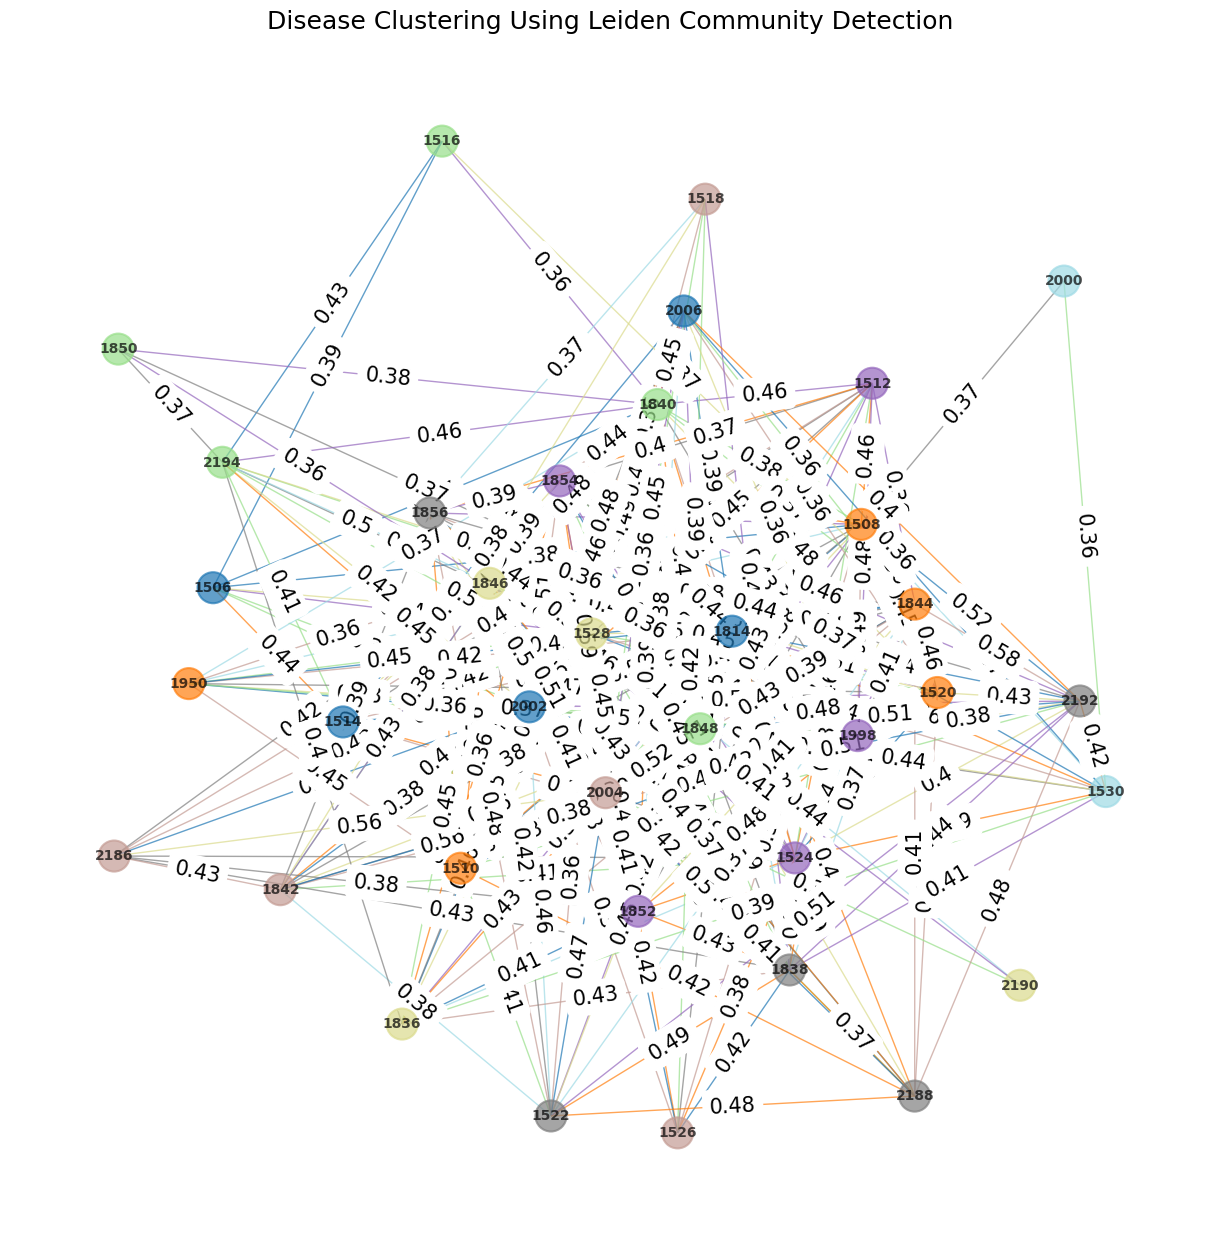

Community 0: [1506, 1510, 1518, 1522, 2000]
['"asthma"', '"emphysema/chronic bronchitis"', '"asbestosis"', '"fibrosing alveolitis/unspecified alveolitis"', '"pneumothorax"']
respiratory/ent: 5
--------------------
Community 1: [1508, 1524, 1528, 1838, 1848]
['"chronic obstructive airways disease/copd"', '"sleep apnoea"', '"pleurisy"', '"bronchitis"', '"nasal polyps"']
respiratory/ent: 5
--------------------
Community 2: [1512, 1520, 1840, 2006, 2194]
['"bronchiectasis"', '"pulmonary fibrosis"', '"nasal/sinus disorder"', '"vertigo"', '"tonsiltis"']
respiratory/ent: 5
--------------------
Community 3: [1514, 1526, 1842, 1844, 1850]
['"interstitial lung disease"', '"respiratory failure"', '"throat or larynx disorder"', '"ear/vestibular disorder"', '"chronic laryngitis"']
respiratory/ent: 5
--------------------
Community 6: [1516, 1998, 2190, 2192]
['"other respiratory problems"', '"alpha-1 antitrypsin deficiency"', '"pleural effusion"', '"tinnitus / tiniitis"']
respiratory/ent: 4
--------

In [398]:
# part1 20250208 计算呼吸系统的社区分群
import networkx as nx
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import leidenalg
import igraph as ig
import matplotlib.pyplot as plt

# 计算疾病间的相似度（cosine相似度）
disease_ids = list(trait_embeddings.keys())
disease_ids = [token_id for token_id in disease_ids if
               final_node_meanings.get(int(traits_df.loc[traits_df['token_id'] == token_id, 'value'].iat[0]), 'Unknown')
               in ['respiratory/ent']]  # ['cardiovascular', 'respiratory/ent']
disease_ids = [disease for disease in disease_ids if disease in trait_embeddings.keys()]
embeddings = np.array([trait_embeddings[disease] for disease in disease_ids if disease in trait_embeddings.keys()])
similarity_matrix = cosine_similarity(embeddings)

# 处理负权重
similarity_matrix[similarity_matrix < 0] = 0

# 构建图
G = nx.Graph()
for i, disease_id_1 in enumerate(disease_ids):
    for j, disease_id_2 in enumerate(disease_ids):
        if i != j:  # 避免自环
            similarity = round(similarity_matrix[i][j], 2)
            if similarity > 0.36:
                G.add_edge(disease_id_1, disease_id_2, weight=similarity)

# 将 NetworkX 图转换为 igraph 图
ig_graph = ig.Graph.from_networkx(G)

# 使用 Leiden 方法进行社区检测
partition = leidenalg.find_partition(
    ig_graph, 
    leidenalg.ModularityVertexPartition, 
    weights='weight', 
    max_comm_size=5,  # 控制每个社区的最大大小
    n_iterations=70,  # 增加迭代次数来细分社区
    seed=9
)


# 原始 community ID 分配结果
old_membership = partition.membership

# 统计每个社区的节点数量
community_counts = Counter(old_membership)

# 按数量降序排列并创建映射表
sorted_communities = sorted(community_counts.items(), key=lambda x: x[1], reverse=True)
id_mapping = {old_id: new_id for new_id, (old_id, _) in enumerate(sorted_communities)}  # 从0开始编号

# 替换为新的编号
new_membership = [id_mapping[old_id] for old_id in old_membership]

# 覆盖原始的 membership
partition._membership = new_membership  
""" """



# 绘制聚类结果
plt.figure(figsize=(12, 12))

# 按照社区分配颜色
colors = [partition.membership[i] for i in range(len(ig_graph.vs))]
# 使用matplotlib的colormap来将社区编号映射到颜色
color_map = plt.cm.get_cmap('tab20', len(set(colors)))  # 'tab20'是一个适合显示多社区的colormap
node_colors = [color_map(c) for c in colors]  # 将每个节点的颜色映射到对应的社区

# 使用spring_layout来优化节点的分布
pos = nx.spring_layout(G, k=1, iterations=30)  # 调整k值和迭代次数来优化布局
node_size = 500  # 节点大小，增加节点的可见度

# 绘制图，使用排序后的pos和node_colors
nx.draw(G, 
        pos=pos, 
        with_labels=True, 
        node_size=node_size, 
        node_color=node_colors, 
        font_size=10, 
        font_weight='bold', 
        edge_color=node_colors, 
        alpha=0.7)

# edge weight labels
d = nx.get_edge_attributes(G, "weight")
edge_labels = {k: d[k] for k in nx.get_edge_attributes(G, 'weight').keys()}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=15)

plt.title("Disease Clustering Using Leiden Community Detection")
plt.show()

# 输出每个社区的疾病ID
community_dict = {}
for i, disease_id in enumerate(disease_ids):
    community_id = partition.membership[i]
    if community_id not in community_dict:
        community_dict[community_id] = []
    community_dict[community_id].append(disease_id)

# 输出每个社区的疾病列表
for community_id, diseases in community_dict.items():
    meanings = [final_node_meanings.get(int(traits_df.loc[traits_df['token_id'] == token_id, 'value'].iat[0]), 'Unknown') for token_id in diseases]
    disease_names = [traits_df.loc[traits_df['token_id'] == token_id, 'token'].iat[0].split("_")[1] for token_id in diseases]
    
    # Count occurrences of each unique value in the meanings list
    values, counts = np.unique(meanings, return_counts=True)
    # Sort by counts in descending order
    sorted_indices = np.argsort(counts)[::-1]  # Reverse the order for descending sort
    sorted_values = values[sorted_indices]
    sorted_counts = counts[sorted_indices]

    print(f"Community {community_id}: {diseases}")
    print(disease_names)
    # Display the sorted result
    for value, count in zip(sorted_values, sorted_counts):
        print(f"{value}: {count}")
    print('-' * 20)


0.46
0.35
0.48
0.38
0.46
0.45
0.39
0.38
0.35
0.45
0.4
0.51
0.48
0.39
0.4
0.39
0.38
0.38
0.51
0.39


/tmp/ipykernel_294938/1894121784.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', len(set(disease_ids)))  # 'tab20'是一个适合显示多社区的colormap


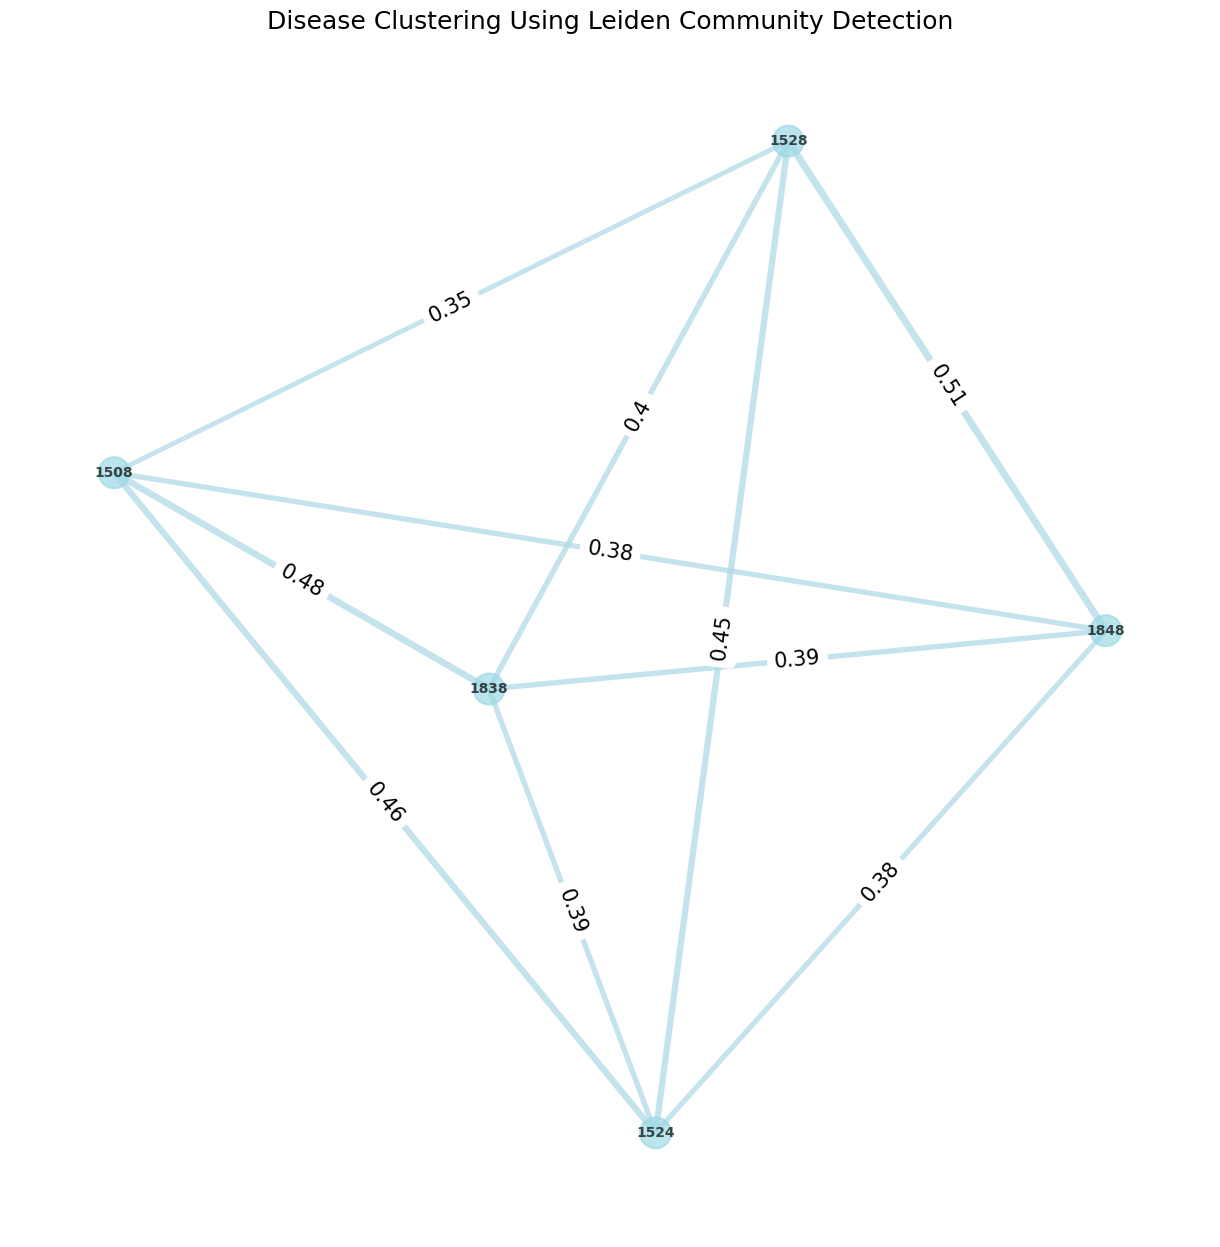

In [451]:
# part2 20250208 画特定社区的网络图   呼吸系统
disease_ids = [1508, 1524, 1528, 1838, 1848]
embeddings = np.array([trait_embeddings[disease] for disease in disease_ids if disease in trait_embeddings.keys()])
similarity_matrix = cosine_similarity(embeddings)

# 处理负权重
similarity_matrix[similarity_matrix < 0] = 0
# 将 NetworkX 图转换为 igraph 图
ig_graph = ig.Graph.from_networkx(G)


# 绘制聚类结果
plt.figure(figsize=(12, 12))


# 使用matplotlib的colormap来将社区编号映射到颜色
color_map = plt.cm.get_cmap('tab20', len(set(disease_ids)))  # 'tab20'是一个适合显示多社区的colormap
node_colors = [color_map(c) for c in disease_ids]  # 将每个节点的颜色映射到对应的社区

# 使用spring_layout来优化节点的分布
pos = nx.spring_layout(G, k=0.1, iterations=30, seed=3)  # 调整k值和迭代次数来优化布局
node_size = 500  # 节点大小，增加节点的可见度

# 构建图
G = nx.Graph()
for i, disease_id_1 in enumerate(disease_ids):
    for j, disease_id_2 in enumerate(disease_ids):
        if i != j:  # 避免自环
            similarity = round(similarity_matrix[i][j], 2)
            print(similarity)
            G.add_edge(disease_id_1, disease_id_2, weight=similarity)

nx.draw(G, 
        pos=pos, 
        with_labels=True, 
        node_size=node_size, 
        node_color=node_colors, 
        font_size=10, 
        font_weight='bold', 
        edge_color= 'lightblue', 
        width=[v*10 for v in list(nx.get_edge_attributes(G, 'weight').values())],  # 设置边的宽度
        alpha=0.7)
# node labels
#nx.draw_networkx_labels(G, pos, font_size=25, font_family="sans-serif")
# edge weight labels
d = nx.get_edge_attributes(G, "weight")
edge_labels = {k: d[k] for k in nx.get_edge_attributes(G, 'weight').keys()}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=15)

plt.title("Disease Clustering Using Leiden Community Detection")
plt.savefig('app2.network.respiratroy.svg', dpi=300, bbox_inches='tight')
plt.show()

In [404]:
# part3 20250208 计算社区中显著性的特征   呼吸系统
import pandas as pd
from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact
import numpy as np
import datetime


# diseases 列表包含我们要分析的所有疾病的 token_id
diseases = community_dict[5]  # 示例疾病的token_id
#diseases = [1506, 1508,1464, 1490]

# 使用 merge 方法进行左连接
all_data_df = data_df

# 创建一个字典存储所有ukb token的频率
all_dict = {'total_ukb_counts': all_data_df.stack().value_counts()}


# 针对每个疾病，选择该疾病患者和没有该疾病的患者
for disease in diseases:
    disease_row = data_df.isin([disease]).any(axis=1)
    #data_df[disease] = np.where(disease_row, 'yes', 'not')
    all_dict[f'{disease}_disease'] = data_df[disease_row].stack().value_counts()

# 创建一个包含所有值的 DataFrame，并将频率为 NaN 的值填充为 0
all_values = pd.DataFrame(all_dict).fillna(0)

# 对频率进行排序
all_values_sorted = all_values.sort_values(by='total_ukb_counts', ascending=False)

# 确保 traits_df 中只包含需要的列
traits_subset = traits_df[['field_id', 'value', 'token_id', 'token', 'trait', 'title', 'category_id', 'category_name']]

# 使用 merge 方法进行左连接
all_values_sorted_rename = all_values_sorted.reset_index().rename(columns={'index': 'token_id'})
merged_df = pd.merge(all_values_sorted_rename, traits_subset, on='token_id', how='left')

merged_df.dropna(inplace=True)

# 计算每个分组的显著性
def calculate_chi2_token(group):
    # 遍历每个 cluster 列
    for cluster_col in [col for col in group.columns if '_disease' in col]:
        chi2_values = []
        p_values = []
        odds_ratios = []
        #print('cluster_col=', cluster_col)
        for index, row in group.iterrows():
            chi2 = None
            p_value = None
            odds_ratio = None

            
            c1_true = row[cluster_col]
            c1_false = group[cluster_col].sum() - c1_true

            total_ukb_true = row['total_ukb_counts']
            total_ukb_false = group['total_ukb_counts'].sum() - total_ukb_true

            contingency_table = [
                [c1_true, total_ukb_true],
                [c1_false, total_ukb_false]
            ]

            # 检查期望频数
            if (np.array(contingency_table) == 0).any():
                expected = 0
            else:
                chi2, p_value, _, expected = chi2_contingency(contingency_table)

            # 如果期望频数中有任何一个单元格 ≤ 5，则使用 Fisher 精确检验
            if (np.array(expected) <= 5).any():
                odds_ratio, p_value = fisher_exact(contingency_table)
            else:
                odds_ratio = (c1_true * total_ukb_false) / (c1_false * total_ukb_true)  # 计算odds ratio
            chi2_values.append(chi2)
            p_values.append(p_value)
            odds_ratios.append(odds_ratio)
        #print(len(chi2_values), len(p_values), len(odds_ratios))
        # 将计算的结果添加到 group 中
        group[f'chi2_{cluster_col}'] = chi2_values
        group[f'p_{cluster_col}'] = p_values
        group[f'odds_{cluster_col}'] = odds_ratios

    return group

# 根据 token 分组并计算 chi2, p_value 和 odds_ratio
merged_df = merged_df.groupby('trait', group_keys=False).apply(calculate_chi2_token)
#merged_df = merged_df.merge(chi2_results_token, on='token_id', how='left')

# 查看结果
#print(merged_df.head())
merged_df.to_csv('app2.chi2_odds_ratio.respiratroy.csv')

# 获取当前时间并打印
current_time = datetime.datetime.now()
print(current_time)



# 获取当前时间并打印
current_time = datetime.datetime.now()
print(current_time)
merged_df[(merged_df.loc[:, merged_df.columns.str.contains('p_')]<(0.05)).all(axis=1)].to_csv('app2.chi2_odds_ratio.respiratroy.sig.csv')



/tmp/ipykernel_294938/650288594.py:89: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged_df = merged_df.groupby('trait', group_keys=False).apply(calculate_chi2_token)


2025-02-08 13:35:47.400780
2025-02-08 13:35:47.400873


/tmp/ipykernel_294938/650288594.py:89: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_df = merged_df.groupby('trait', group_keys=False).apply(calculate_chi2_token)


In [46]:
# part3 20250302 计算社区中显著性的特征   呼吸系统
import pandas as pd
from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact
import numpy as np
import datetime


# diseases 列表包含我们要分析的所有疾病的 token_id
#diseases = community_dict[5]  # 示例疾病的token_id
diseases = [1508, 1524, 1528, 1838, 1848]

# 使用 merge 方法进行左连接
all_data_df = data_df

# 创建一个字典存储所有ukb token的频率
all_dict = {'total_ukb_counts': all_data_df.stack().value_counts()}

# 针对每个疾病，选择该疾病患者和没有该疾病的患者
for disease in diseases:
    disease_row = data_df.isin([disease]).any(axis=1)
    #data_df[disease] = np.where(disease_row, 'yes', 'not')
    all_dict[f'{disease}_disease'] = data_df[disease_row].stack().value_counts()

# 创建一个包含所有值的 DataFrame，并将频率为 NaN 的值填充为 0
all_values = pd.DataFrame(all_dict).fillna(0)

# 对频率进行排序
all_values_sorted = all_values.sort_values(by='total_ukb_counts', ascending=False)

# 确保 traits_df 中只包含需要的列
traits_subset = traits_df[['field_id', 'value', 'token_id', 'token', 'trait', 'title', 'category_id', 'category_name']]

# 使用 merge 方法进行左连接
all_values_sorted_rename = all_values_sorted.reset_index().rename(columns={'index': 'token_id'})
merged_df = pd.merge(all_values_sorted_rename, traits_subset, on='token_id', how='left')

merged_df.dropna(inplace=True)

# 计算每个分组的显著性
def calculate_chi2_token(group):
    """
    对同一 trait 的所有行逐一计算 (chi2, p-value, OR 以及每一行 OR 的95% CI)，
    最后再为该 group 每个_disease列计算该组内 p 值均值、OR 均值及 OR 均值的95% CI
    """
    # 找到所有含有 '_disease' 的列（即不同疾病）
    disease_cols = [col for col in group.columns if '_disease' in col]
    for cluster_col in disease_cols:
        chi2_values = []
        p_values = []
        odds_ratios = []
        ci_lower_ind_list = []
        ci_upper_ind_list = []
        # 对每一行计算
        for index, row in group.iterrows():
            chi2 = None
            p_value = None
            odds_ratio = None

            c1_true = row[cluster_col]
            c1_false = group[cluster_col].sum() - c1_true

            total_ukb_true = row['total_ukb_counts']
            total_ukb_false = group['total_ukb_counts'].sum() - total_ukb_true

            contingency_table = [
                [c1_true, total_ukb_true],
                [c1_false, total_ukb_false]
            ]

            # 检查期望频数
            if (np.array(contingency_table) == 0).any():
                expected = 0
            else:
                chi2, p_value, _, expected = chi2_contingency(contingency_table)

            # 如果期望频数中有任何一个单元格 ≤ 5，则使用 Fisher 精确检验
            if (np.array(expected) <= 5).any():
                odds_ratio, p_value = fisher_exact(contingency_table)
            else:
                odds_ratio = (c1_true * total_ukb_false) / (c1_false * total_ukb_true)
            chi2_values.append(chi2)
            p_values.append(p_value)
            odds_ratios.append(odds_ratio)
            
            # 计算每个 OR 的 95% CI
            # 定义 2×2 表格的四个单元格：
            # a = c1_true, b = total_ukb_true - c1_true, c = c1_false, d = total_ukb_false - c1_false
            a = c1_true
            b = total_ukb_true - c1_true
            c = c1_false
            d = total_ukb_false - c1_false
            # 如果任一单元格为 0，则加 0.5 做连续性校正
            if a == 0 or b == 0 or c == 0 or d == 0:
                a += 0.5
                b += 0.5
                c += 0.5
                d += 0.5
            # 使用校正后的数值计算 OR
            or_corrected = (a * d) / (b * c)
            se_log_or = np.sqrt(1/a + 1/b + 1/c + 1/d)
            ci_lower_ind = np.exp(np.log(or_corrected) - 1.96 * se_log_or)
            ci_upper_ind = np.exp(np.log(or_corrected) + 1.96 * se_log_or)
            ci_lower_ind_list.append(ci_lower_ind)
            ci_upper_ind_list.append(ci_upper_ind)
            
        # 将每一行计算的结果写入 group
        group[f'chi2_{cluster_col}'] = chi2_values
        group[f'p_{cluster_col}'] = p_values
        group[f'odds_{cluster_col}'] = odds_ratios
        group[f'ci_lower_ind_{cluster_col}'] = ci_lower_ind_list
        group[f'ci_upper_ind_{cluster_col}'] = ci_upper_ind_list
        
    # ============ 计算该 group (同一个 trait) 下的 p 值均值、OR 均值及 OR 均值的 95% CI ============

    # 对每一行计算
    for index, row in group.iterrows():
        # 全组的 p-value 和 OR 序列
        p_series = row[[f'p_{cluster_col}' for cluster_col in disease_cols]]
        or_series = row[[f'odds_{cluster_col}' for cluster_col in disease_cols]]
        ci_lower_series = row[[f'ci_lower_ind_{cluster_col}' for cluster_col in disease_cols]]
        ci_upper_series = row[[f'ci_upper_ind_{cluster_col}' for cluster_col in disease_cols]]
        
        mean_p = p_series.mean()
        mean_or = or_series.mean()
        mean_ci_lower = ci_lower_series.mean()
        mean_ci_upper = ci_upper_series.mean()
        """
        # 计算 OR 均值的 95% CI (简单正态近似)
        n = len(or_series)
        if n > 1:
            std_or = or_series.std(ddof=1)  # 样本标准差
            se_or = std_or / np.sqrt(n)     # 均值的标准误
            ci_lower = mean_or - 1.96 * se_or
            ci_upper = mean_or + 1.96 * se_or
        else:
            ci_lower = mean_or
            ci_upper = mean_or
        group.loc[index, f'mean_ci_lower_{cluster_col}'] = ci_lower
        group.loc[index, f'mean_ci_upper_{cluster_col}'] = ci_upper
        """
        # 将汇总指标写回每一行
        group.loc[index, f'Pmean'] = mean_p
        group.loc[index, f'mean_or'] = mean_or
        group.loc[index, f'mean_ci_lower'] = mean_ci_lower
        group.loc[index, f'mean_ci_upper'] = mean_ci_upper

            
    return group

# 根据 token 分组并计算 chi2, p-value, OR 及其95% CI
merged_df = merged_df.groupby('trait', group_keys=False).apply(calculate_chi2_token)
#merged_df = merged_df.merge(chi2_results_token, on='token_id', how='left')

# 保存结果到 CSV 文件
merged_df.to_csv('app2.chi2_odds_ratio.respiratroy.csv')

# 打印当前时间
current_time = datetime.datetime.now()
print(current_time)

# 再次打印当前时间并保存显著性结果
current_time = datetime.datetime.now()
print(current_time)
merged_df[(merged_df.loc[:, merged_df.columns.str.contains('p_')] < (0.05)).all(axis=1)].to_csv('app2.chi2_odds_ratio.respiratroy.sig.csv')


/tmp/ipykernel_744466/2789402462.py:137: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged_df = merged_df.groupby('trait', group_keys=False).apply(calculate_chi2_token)
/tmp/ipykernel_744466/2789402462.py:137: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_df = merged_df.groupby('trait', group_keys=False).apply(calculate_chi2_token)


计算完成时间： 2025-03-03 11:35:22.582454
结束时间： 2025-03-03 11:35:22.589380


In [50]:
# part3 20250302 计算社区中显著性的特征   呼吸系统   添加FDR值

import pandas as pd
import numpy as np
import datetime
from scipy.stats import chi2_contingency, fisher_exact
from statsmodels.stats.multitest import multipletests

# ==============================
# 1. 准备数据 (与原代码相同的部分)
# ==============================

# diseases 列表包含我们要分析的所有疾病的 token_id
diseases = [1508, 1524, 1528, 1838, 1848]

all_data_df = data_df

# 创建一个字典存储所有ukb token的频率
all_dict = {'total_ukb_counts': all_data_df.stack().value_counts()}

# 针对每个疾病，选择该疾病患者和没有该疾病的患者
for disease in diseases:
    disease_row = data_df.isin([disease]).any(axis=1)
    all_dict[f'{disease}_disease'] = data_df[disease_row].stack().value_counts()

# 创建一个包含所有值的 DataFrame，并将频率为 NaN 的值填充为 0
all_values = pd.DataFrame(all_dict).fillna(0)
all_values_sorted = all_values.sort_values(by='total_ukb_counts', ascending=False)

# 确保 traits_df 中只包含需要的列
traits_subset = traits_df[['field_id', 'value', 'token_id', 'token', 'trait', 'title', 'category_id', 'category_name']]

all_values_sorted_rename = all_values_sorted.reset_index().rename(columns={'index': 'token_id'})
merged_df = pd.merge(all_values_sorted_rename, traits_subset, on='token_id', how='left')
merged_df.dropna(inplace=True)

def calculate_chi2_token(group):
    """
    对同一 trait 的所有行逐一计算 (chi2, p-value, OR 以及每一行 OR 的95% CI)，
    最后再为该 group 每个_disease列计算该组内 p 值均值、OR 均值及 OR 均值的95% CI
    """
    disease_cols = [col for col in group.columns if '_disease' in col]
    
    for cluster_col in disease_cols:
        chi2_values = []
        p_values = []
        odds_ratios = []
        ci_lower_ind_list = []
        ci_upper_ind_list = []
        
        for index, row in group.iterrows():
            chi2 = None
            p_value = None
            odds_ratio = None

            c1_true = row[cluster_col]
            c1_false = group[cluster_col].sum() - c1_true

            total_ukb_true = row['total_ukb_counts']
            total_ukb_false = group['total_ukb_counts'].sum() - total_ukb_true

            contingency_table = [
                [c1_true, total_ukb_true],
                [c1_false, total_ukb_false]
            ]

            # 检查期望频数
            if (np.array(contingency_table) == 0).any():
                expected = 0
            else:
                chi2, p_value, _, expected = chi2_contingency(contingency_table)

            # 如果期望频数中有任何一个单元格 ≤ 5，则使用 Fisher 精确检验
            if isinstance(expected, np.ndarray):
                if (expected <= 5).any():
                    odds_ratio, p_value = fisher_exact(contingency_table)
                else:
                    odds_ratio = (c1_true * total_ukb_false) / (c1_false * total_ukb_true)
            else:
                # 如果上面没算出期望值，这里也改用 Fisher
                odds_ratio, p_value = fisher_exact(contingency_table)
            
            chi2_values.append(chi2)
            p_values.append(p_value)
            odds_ratios.append(odds_ratio)
            
            # 计算每个 OR 的 95% CI
            a = c1_true
            b = total_ukb_true - c1_true
            c = c1_false
            d = total_ukb_false - c1_false
            # 连续性校正
            if a == 0 or b == 0 or c == 0 or d == 0:
                a += 0.5
                b += 0.5
                c += 0.5
                d += 0.5

            or_corrected = (a * d) / (b * c)
            se_log_or = np.sqrt(1/a + 1/b + 1/c + 1/d)
            ci_lower_ind = np.exp(np.log(or_corrected) - 1.96 * se_log_or)
            ci_upper_ind = np.exp(np.log(or_corrected) + 1.96 * se_log_or)
            
            ci_lower_ind_list.append(ci_lower_ind)
            ci_upper_ind_list.append(ci_upper_ind)
        
        # 将每一行计算的结果写入 group
        group[f'chi2_{cluster_col}'] = chi2_values
        group[f'p_{cluster_col}'] = p_values
        group[f'odds_{cluster_col}'] = odds_ratios
        group[f'ci_lower_ind_{cluster_col}'] = ci_lower_ind_list
        group[f'ci_upper_ind_{cluster_col}'] = ci_upper_ind_list
        
    # ============ 计算该 group (同一个 trait) 下的 p 值均值、OR 均值及 OR 均值的 95% CI ============
    for index, row in group.iterrows():
        # 全组的 p-value 和 OR 序列
        p_series = row[[f'p_{col}' for col in disease_cols]]
        or_series = row[[f'odds_{col}' for col in disease_cols]]
        ci_lower_series = row[[f'ci_lower_ind_{col}' for col in disease_cols]]
        ci_upper_series = row[[f'ci_upper_ind_{col}' for col in disease_cols]]
        
        mean_p = p_series.mean()
        mean_or = or_series.mean()
        mean_ci_lower = ci_lower_series.mean()
        mean_ci_upper = ci_upper_series.mean()

        group.loc[index, 'Pmean'] = mean_p
        group.loc[index, 'mean_or'] = mean_or
        group.loc[index, 'mean_ci_lower'] = mean_ci_lower
        group.loc[index, 'mean_ci_upper'] = mean_ci_upper

    return group

# ==============
# 2. 先做原始计算
# ==============
merged_df = merged_df.groupby('trait', group_keys=False).apply(calculate_chi2_token)

# 找到所有 以 'p_' 开头的列
p_cols = [col for col in merged_df.columns if col.startswith('p_')]

# =========================
# 3. **逐列**做多重校正
# =========================
for col in p_cols:
    # 取这一列所有行的 p 值
    p_array = merged_df[col].values
    # 对该列单独做 FDR-BH 矫正
    reject, qvals, _, _ = multipletests(p_array, alpha=0.05, method='fdr_bh')
    # 建立一个新列，存放校正后的 q 值
    merged_df[f'BH_{col}'] = qvals

# =================================================
# 4. 添加 mean_q 列：汇总每行所有 BH_ 列的平均值
# =================================================
bh_cols = [f'BH_{c}' for c in p_cols]
merged_df['mean_q'] = merged_df[bh_cols].mean(axis=1)

# 5. 保存结果到 CSV
merged_df.to_csv('app2.chi2_odds_ratio.respiratroy.csv', index=False)

# 打印时间
current_time = datetime.datetime.now()
print("计算完成时间：", current_time)

# 如果需要根据校正后 q 值(比如要所有 BH 列都 <0.05 * len(p_cols))来筛选：
sig_mask = (merged_df[bh_cols] < 0.05 * len(p_cols)).all(axis=1)
sig_df = merged_df[sig_mask]
sig_df.to_csv('app2.chi2_odds_ratio.respiratroy.sig.csv', index=False)

# 再次打印时间
current_time = datetime.datetime.now()
print("结束时间：", current_time)


/tmp/ipykernel_744466/4023389540.py:137: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged_df = merged_df.groupby('trait', group_keys=False).apply(calculate_chi2_token)
/tmp/ipykernel_744466/4023389540.py:137: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_df = merged_df.groupby('trait', group_keys=False).apply(calculate_chi2_token)


计算完成时间： 2025-03-03 11:58:19.184954
结束时间： 2025-03-03 11:58:19.192569


/tmp/ipykernel_744466/2449084720.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', len(set(colors)))  # 'tab20'是一个适合显示多社区的colormap


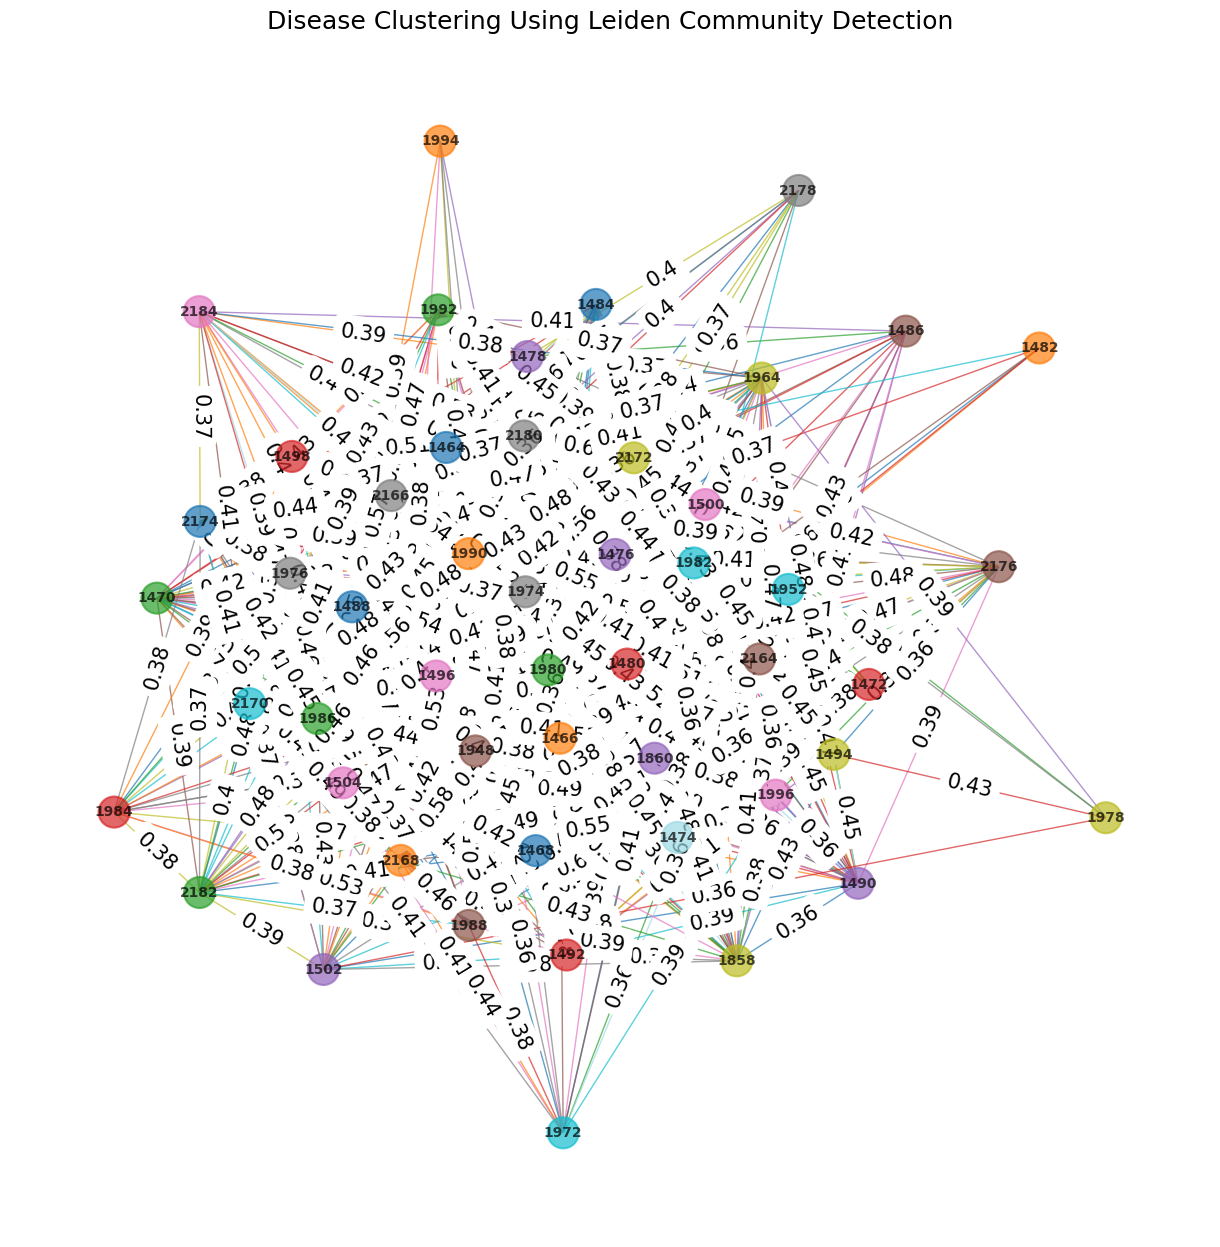

Community 0: [1464, 1468, 1482, 1486, 1990]
['"hypertension"', '"peripheral vascular disease"', '"heart arrhythmia"', '"cardiomyopathy"', '"aortic aneurysm"']
cardiovascular: 5
--------------------
Community 1: [1466, 1978, 1986, 2164, 2176]
['"heart/cardiac problem"', '"sick sinus syndrome"', '"aortic stenosis"', '"ischaemic stroke"', '"pericarditis"']
cardiovascular: 5
--------------------
Community 2: [1470, 1952, 1974, 2174, 2180]
['"venous thromboembolic disease"', '"high cholesterol"', '"wolff parkinson white / wpw syndrome"', '"hypertrophic cardiomyopathy (hcm / hocm)"', '"aortic aneurysm rupture"']
cardiovascular: 5
--------------------
Community 3: [1472, 1480, 1490, 1494, 1972]
['"essential hypertension"', '"heart failure/pulmonary odema"', '"stroke"', '"subdural haemorrhage/haematoma"', '"atrial flutter"']
cardiovascular: 5
--------------------
Community 10: [1474]
['"gestational hypertension/pre-eclampsia"']
cardiovascular: 1
--------------------
Community 4: [1476, 1478, 1

In [397]:
# part1 20250208 计算社区分群  心血管系统
import networkx as nx
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import leidenalg
import igraph as ig
import matplotlib.pyplot as plt
from collections import Counter

# 计算疾病间的相似度（cosine相似度）
disease_ids = list(trait_embeddings.keys())
disease_ids = [token_id for token_id in disease_ids if
               final_node_meanings.get(int(traits_df.loc[traits_df['token_id'] == token_id, 'value'].iat[0]), 'Unknown')
               in ['cardiovascular']] # ['cardiovascular', 'respiratory/ent']
disease_ids = [disease for disease in disease_ids if disease in trait_embeddings.keys()]
embeddings = np.array([trait_embeddings[disease] for disease in disease_ids if disease in trait_embeddings.keys()])
similarity_matrix = cosine_similarity(embeddings)

# 处理负权重
similarity_matrix[similarity_matrix < 0] = 0

# 构建图
G = nx.Graph()
for i, disease_id_1 in enumerate(disease_ids):
    for j, disease_id_2 in enumerate(disease_ids):
        if i != j:  # 避免自环
            similarity = round(similarity_matrix[i][j], 2)
            if similarity > 0.36:
                G.add_edge(disease_id_1, disease_id_2, weight=similarity)

# 将 NetworkX 图转换为 igraph 图
ig_graph = ig.Graph.from_networkx(G)

# 使用 Leiden 方法进行社区检测
partition = leidenalg.find_partition(
    ig_graph, 
    leidenalg.ModularityVertexPartition, 
    weights='weight', 
    max_comm_size=5,  # 控制每个社区的最大大小
    n_iterations=70,  # 增加迭代次数来细分社区
    seed=9
)

# 原始 community ID 分配结果
old_membership = partition.membership

# 统计每个社区的节点数量
community_counts = Counter(old_membership)

# 按数量降序排列并创建映射表
sorted_communities = sorted(community_counts.items(), key=lambda x: x[1], reverse=True)
id_mapping = {old_id: new_id for new_id, (old_id, _) in enumerate(sorted_communities)}  # 从0开始编号

# 替换为新的编号
new_membership = [id_mapping[old_id] for old_id in old_membership]

# 覆盖原始的 membership
partition._membership = new_membership  
""" """

# 绘制聚类结果
plt.figure(figsize=(12, 12))

# 按照社区分配颜色
colors = [partition.membership[i] for i in range(len(ig_graph.vs))]
# 使用matplotlib的colormap来将社区编号映射到颜色
color_map = plt.cm.get_cmap('tab20', len(set(colors)))  # 'tab20'是一个适合显示多社区的colormap
node_colors = [color_map(c) for c in colors]  # 将每个节点的颜色映射到对应的社区

# 使用spring_layout来优化节点的分布
pos = nx.spring_layout(G, k=1, iterations=30)  # 调整k值和迭代次数来优化布局
node_size = 500  # 节点大小，增加节点的可见度

# 绘制图，使用排序后的pos和node_colors
nx.draw(G, 
        pos=pos, 
        with_labels=True, 
        node_size=node_size, 
        node_color=node_colors, 
        font_size=10, 
        font_weight='bold', 
        edge_color=node_colors, 
        alpha=0.7)

# edge weight labels
d = nx.get_edge_attributes(G, "weight")
edge_labels = {k: d[k] for k in nx.get_edge_attributes(G, 'weight').keys()}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=15)

plt.title("Disease Clustering Using Leiden Community Detection")
plt.show()

# 输出每个社区的疾病ID
community_dict = {}
for i, disease_id in enumerate(disease_ids):
    community_id = partition.membership[i]
    if community_id not in community_dict:
        community_dict[community_id] = []
    community_dict[community_id].append(disease_id)

# 输出每个社区的疾病列表
for community_id, diseases in community_dict.items():
    meanings = [final_node_meanings.get(int(traits_df.loc[traits_df['token_id'] == token_id, 'value'].iat[0]), 'Unknown') for token_id in diseases]
    disease_names = [traits_df.loc[traits_df['token_id'] == token_id, 'token'].iat[0].split("_")[1] for token_id in diseases]
    
    # Count occurrences of each unique value in the meanings list
    values, counts = np.unique(meanings, return_counts=True)
    # Sort by counts in descending order
    sorted_indices = np.argsort(counts)[::-1]  # Reverse the order for descending sort
    sorted_values = values[sorted_indices]
    sorted_counts = counts[sorted_indices]

    print(f"Community {community_id}: {diseases}")
    print(disease_names)
    # Display the sorted result
    for value, count in zip(sorted_values, sorted_counts):
        print(f"{value}: {count}")
    print('-' * 20)


0.46
0.21
0.44
0.5
0.46
0.27
0.37
0.58
0.21
0.27
0.23
0.37
0.44
0.37
0.23
0.37
0.5
0.58
0.37
0.37


/tmp/ipykernel_294938/2759260563.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', len(set(disease_ids)))  # 'tab20'是一个适合显示多社区的colormap


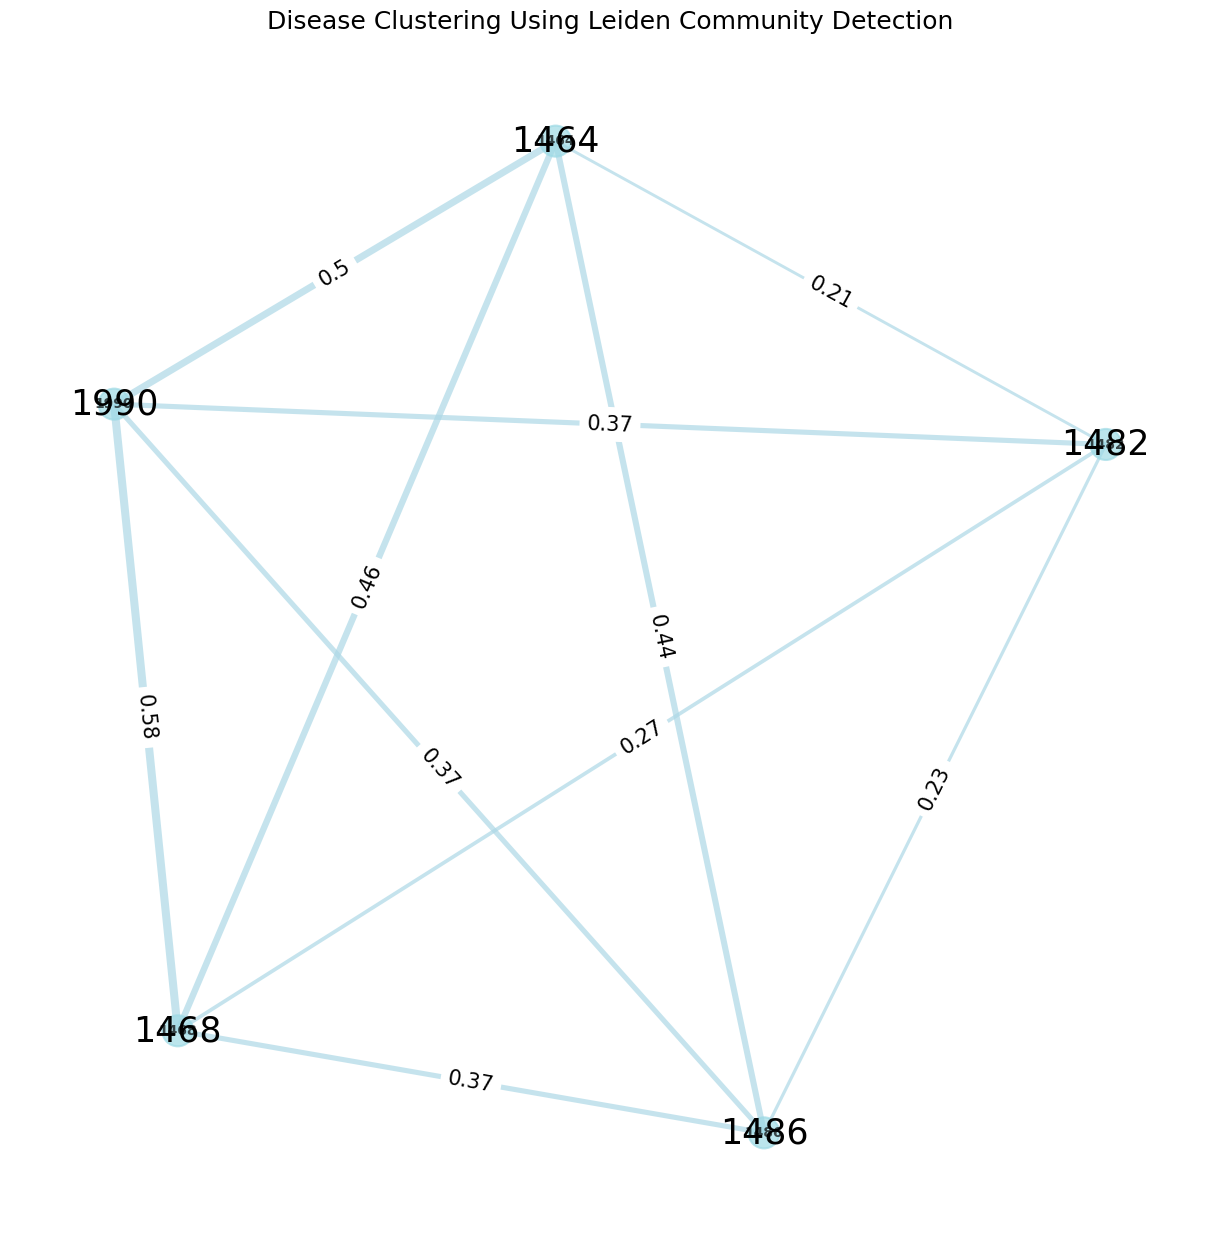

In [433]:
# part2 20250208 画特定社区的网络图   心血管系统
disease_ids = [1464, 1468, 1482, 1486, 1990]
embeddings = np.array([trait_embeddings[disease] for disease in disease_ids if disease in trait_embeddings.keys()])
similarity_matrix = cosine_similarity(embeddings)

# 处理负权重
similarity_matrix[similarity_matrix < 0] = 0
# 将 NetworkX 图转换为 igraph 图
ig_graph = ig.Graph.from_networkx(G)


# 绘制聚类结果
plt.figure(figsize=(12, 12))


# 使用matplotlib的colormap来将社区编号映射到颜色
color_map = plt.cm.get_cmap('tab20', len(set(disease_ids)))  # 'tab20'是一个适合显示多社区的colormap
node_colors = [color_map(c) for c in disease_ids]  # 将每个节点的颜色映射到对应的社区

# 使用spring_layout来优化节点的分布
pos = nx.spring_layout(G, k=0.4, iterations=150, seed=3) # 调整k值和迭代次数来优化布局
node_size = 500  # 节点大小，增加节点的可见度

# 构建图
G = nx.Graph()
for i, disease_id_1 in enumerate(disease_ids):
    for j, disease_id_2 in enumerate(disease_ids):
        if i != j:  # 避免自环
            similarity = round(similarity_matrix[i][j], 2)
            print(similarity)
            G.add_edge(disease_id_1, disease_id_2, weight=similarity)

nx.draw(G, 
        pos=pos, 
        with_labels=True, 
        node_size=node_size, 
        node_color=node_colors, 
        font_size=10, 
        font_weight='bold', 
        edge_color= 'lightblue', 
        width=[v*10 for v in list(nx.get_edge_attributes(G, 'weight').values())],  # 设置边的宽度
        alpha=0.7)


# node labels
nx.draw_networkx_labels(G, pos, font_size=25, font_family="sans-serif")
# edge weight labels
d = nx.get_edge_attributes(G, "weight")
edge_labels = {k: d[k] for k in nx.get_edge_attributes(G, 'weight').keys()}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=15)

plt.title("Disease Clustering Using Leiden Community Detection")
plt.savefig('app2.network.cardiovascular.svg', dpi=300, bbox_inches='tight')
plt.show()

In [51]:
#勿删 part3 20250302 计算社区中显著性的特征   心血管系统  添加FDR值

import pandas as pd
import numpy as np
import datetime
from scipy.stats import chi2_contingency, fisher_exact
from statsmodels.stats.multitest import multipletests

# ==============================
# 1. 准备数据 (与原代码相同的部分)
# ==============================

# diseases 列表包含我们要分析的所有疾病的 token_id
diseases = [1464, 1468, 1482, 1486, 1990]

all_data_df = data_df

# 创建一个字典存储所有ukb token的频率
all_dict = {'total_ukb_counts': all_data_df.stack().value_counts()}

# 针对每个疾病，选择该疾病患者和没有该疾病的患者
for disease in diseases:
    disease_row = data_df.isin([disease]).any(axis=1)
    all_dict[f'{disease}_disease'] = data_df[disease_row].stack().value_counts()

# 创建一个包含所有值的 DataFrame，并将频率为 NaN 的值填充为 0
all_values = pd.DataFrame(all_dict).fillna(0)
all_values_sorted = all_values.sort_values(by='total_ukb_counts', ascending=False)

# 确保 traits_df 中只包含需要的列
traits_subset = traits_df[['field_id', 'value', 'token_id', 'token', 'trait', 'title', 'category_id', 'category_name']]

all_values_sorted_rename = all_values_sorted.reset_index().rename(columns={'index': 'token_id'})
merged_df = pd.merge(all_values_sorted_rename, traits_subset, on='token_id', how='left')
merged_df.dropna(inplace=True)

def calculate_chi2_token(group):
    """
    对同一 trait 的所有行逐一计算 (chi2, p-value, OR 以及每一行 OR 的95% CI)，
    最后再为该 group 每个_disease列计算该组内 p 值均值、OR 均值及 OR 均值的95% CI
    """
    disease_cols = [col for col in group.columns if '_disease' in col]
    
    for cluster_col in disease_cols:
        chi2_values = []
        p_values = []
        odds_ratios = []
        ci_lower_ind_list = []
        ci_upper_ind_list = []
        
        for index, row in group.iterrows():
            chi2 = None
            p_value = None
            odds_ratio = None

            c1_true = row[cluster_col]
            c1_false = group[cluster_col].sum() - c1_true

            total_ukb_true = row['total_ukb_counts']
            total_ukb_false = group['total_ukb_counts'].sum() - total_ukb_true

            contingency_table = [
                [c1_true, total_ukb_true],
                [c1_false, total_ukb_false]
            ]

            # 检查期望频数
            if (np.array(contingency_table) == 0).any():
                expected = 0
            else:
                chi2, p_value, _, expected = chi2_contingency(contingency_table)

            # 如果期望频数中有任何一个单元格 ≤ 5，则使用 Fisher 精确检验
            if isinstance(expected, np.ndarray):
                if (expected <= 5).any():
                    odds_ratio, p_value = fisher_exact(contingency_table)
                else:
                    odds_ratio = (c1_true * total_ukb_false) / (c1_false * total_ukb_true)
            else:
                # 如果上面没算出期望值，这里也改用 Fisher
                odds_ratio, p_value = fisher_exact(contingency_table)
            
            chi2_values.append(chi2)
            p_values.append(p_value)
            odds_ratios.append(odds_ratio)
            
            # 计算每个 OR 的 95% CI
            a = c1_true
            b = total_ukb_true - c1_true
            c = c1_false
            d = total_ukb_false - c1_false
            # 连续性校正
            if a == 0 or b == 0 or c == 0 or d == 0:
                a += 0.5
                b += 0.5
                c += 0.5
                d += 0.5

            or_corrected = (a * d) / (b * c)
            se_log_or = np.sqrt(1/a + 1/b + 1/c + 1/d)
            ci_lower_ind = np.exp(np.log(or_corrected) - 1.96 * se_log_or)
            ci_upper_ind = np.exp(np.log(or_corrected) + 1.96 * se_log_or)
            
            ci_lower_ind_list.append(ci_lower_ind)
            ci_upper_ind_list.append(ci_upper_ind)
        
        # 将每一行计算的结果写入 group
        group[f'chi2_{cluster_col}'] = chi2_values
        group[f'p_{cluster_col}'] = p_values
        group[f'odds_{cluster_col}'] = odds_ratios
        group[f'ci_lower_ind_{cluster_col}'] = ci_lower_ind_list
        group[f'ci_upper_ind_{cluster_col}'] = ci_upper_ind_list
        
    # ============ 计算该 group (同一个 trait) 下的 p 值均值、OR 均值及 OR 均值的 95% CI ============
    for index, row in group.iterrows():
        # 全组的 p-value 和 OR 序列
        p_series = row[[f'p_{col}' for col in disease_cols]]
        or_series = row[[f'odds_{col}' for col in disease_cols]]
        ci_lower_series = row[[f'ci_lower_ind_{col}' for col in disease_cols]]
        ci_upper_series = row[[f'ci_upper_ind_{col}' for col in disease_cols]]
        
        mean_p = p_series.mean()
        mean_or = or_series.mean()
        mean_ci_lower = ci_lower_series.mean()
        mean_ci_upper = ci_upper_series.mean()

        group.loc[index, 'Pmean'] = mean_p
        group.loc[index, 'mean_or'] = mean_or
        group.loc[index, 'mean_ci_lower'] = mean_ci_lower
        group.loc[index, 'mean_ci_upper'] = mean_ci_upper

    return group

# ==============
# 2. 先做原始计算
# ==============
merged_df = merged_df.groupby('trait', group_keys=False).apply(calculate_chi2_token)

# 找到所有 以 'p_' 开头的列
p_cols = [col for col in merged_df.columns if col.startswith('p_')]

# =========================
# 3. **逐列**做多重校正
# =========================
for col in p_cols:
    # 取这一列所有行的 p 值
    p_array = merged_df[col].values
    # 对该列单独做 FDR-BH 矫正
    reject, qvals, _, _ = multipletests(p_array, alpha=0.05, method='fdr_bh')
    # 建立一个新列，存放校正后的 q 值
    merged_df[f'BH_{col}'] = qvals

# =================================================
# 4. 添加 mean_q 列：汇总每行所有 BH_ 列的平均值
# =================================================
bh_cols = [f'BH_{c}' for c in p_cols]
merged_df['mean_q'] = merged_df[bh_cols].mean(axis=1)

# 5. 保存结果到 CSV
merged_df.to_csv('app2.chi2_odds_ratio.cardiovascular.csv', index=False)

# 打印时间
current_time = datetime.datetime.now()
print("计算完成时间：", current_time)

# 如果需要根据校正后 q 值(比如要所有 BH 列都 <0.05 * len(p_cols))来筛选：
sig_mask = (merged_df[bh_cols] < 0.05 * len(p_cols)).all(axis=1)
sig_df = merged_df[sig_mask]
sig_df.to_csv('app2.chi2_odds_ratio.cardiovascular.sig.csv', index=False)

# 再次打印时间
current_time = datetime.datetime.now()
print("结束时间：", current_time)


/tmp/ipykernel_744466/1609595912.py:137: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged_df = merged_df.groupby('trait', group_keys=False).apply(calculate_chi2_token)
/tmp/ipykernel_744466/1609595912.py:137: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_df = merged_df.groupby('trait', group_keys=False).apply(calculate_chi2_token)


计算完成时间： 2025-03-03 12:01:22.116936
结束时间： 2025-03-03 12:01:22.123547


In [417]:
# APP3 计算特定疾病的显著性的特征   breast cancer

import pandas as pd
import numpy as np
import datetime
from scipy.stats import chi2_contingency, fisher_exact
from statsmodels.stats.multitest import multipletests

# ==============================
# 1. 准备数据 (与原代码相同的部分)
# ==============================

# diseases 列表包含我们要分析的所有疾病的 token_id
diseases = [1938, 1304, 1378] # gout 1938， breast cancer 1304； cervical cancer 1378

all_data_df = data_df.iloc[:450000, :]

# 创建一个字典存储所有ukb token的频率
all_dict = {'total_ukb_counts': all_data_df.stack().value_counts()}   # 所有人里面value token的计数

# 针对每个疾病，选择该疾病患者和没有该疾病的患者
for disease in diseases:
    disease_row = all_data_df.isin([disease]).any(axis=1)
    all_dict[f'{disease}_disease'] = all_data_df[disease_row].stack().value_counts()
    all_dict[f'{disease}_controls'] = all_data_df[~disease_row].stack().value_counts() 

# 创建一个包含所有值的 DataFrame，并将频率为 NaN 的值填充为 0
all_values = pd.DataFrame(all_dict).fillna(0)
all_values_sorted = all_values.sort_values(by='total_ukb_counts', ascending=False)

# 确保 traits_df 中只包含需要的列
traits_subset = traits_df[['field_id', 'value', 'token_id', 'token', 'trait', 'title', 'category_id', 'category_name']]

all_values_sorted_rename = all_values_sorted.reset_index().rename(columns={'index': 'token_id'})
merged_df = pd.merge(all_values_sorted_rename, traits_subset, on='token_id', how='left')
merged_df.dropna(inplace=True)

def calculate_chi2_token(group):
    """
    对同一 trait 的所有行逐一计算 (chi2, p-value, OR 以及每一行 OR 的95% CI)，
    最后再为该 group 每个_disease列计算该组内 p 值均值、OR 均值及 OR 均值的95% CI
    """
    disease_cols = [col for col in group.columns if '_disease' in col]
    
    for cluster_col in disease_cols:
        chi2_values = []
        p_values = []
        odds_ratios = []
        ci_lower_ind_list = []
        ci_upper_ind_list = []

        c1_true_list = []
        c1_false_list = []
        control_true_list = []
        control_false_list = []
        c1_total_list = []
        control_total_list = []
        
        
        
        for index, row in group.iterrows():
            chi2 = None
            p_value = None
            odds_ratio = None

            c1_true = row[cluster_col]
            c1_false = group[cluster_col].sum() - c1_true

            control_col = f"{cluster_col.replace('_disease', '')}_controls"
            control_true = row[control_col]
            control_false = group[control_col].sum() - control_true

            contingency_table = [
                [c1_true, control_true],
                [c1_false, control_false]
            ]
            #print(contingency_table)

            # 检查期望频数
            if (np.array(contingency_table) == 0).any():
                expected = 0
            else:
                chi2, p_value, _, expected = chi2_contingency(contingency_table)

            # 如果期望频数中有任何一个单元格 ≤ 5，则使用 Fisher 精确检验
            if isinstance(expected, np.ndarray):
                if (expected <= 5).any():
                    odds_ratio, p_value = fisher_exact(contingency_table)
                else:
                    odds_ratio = (c1_true * control_false) / (c1_false * control_true)
            else:
                # 如果上面没算出期望值，这里也改用 Fisher
                odds_ratio, p_value = fisher_exact(contingency_table)
            
            chi2_values.append(chi2)
            p_values.append(p_value)
            odds_ratios.append(odds_ratio)

            c1_true_list.append(c1_true)
            c1_false_list.append(c1_false)
            control_true_list.append(control_true)
            control_false_list.append(control_false)
            c1_total_list.append(c1_true + c1_false)
            control_total_list.append(control_true + control_false)
            
            # 计算每个 OR 的 95% CI
            a = c1_true
            b = control_true - c1_true
            c = c1_false
            d = control_false - c1_false
            # 连续性校正
            if a == 0 or b == 0 or c == 0 or d == 0:
                a += 0.5
                b += 0.5
                c += 0.5
                d += 0.5

            or_corrected = (a * d) / (b * c)
            se_log_or = np.sqrt(1/a + 1/b + 1/c + 1/d)
            ci_lower_ind = np.exp(np.log(or_corrected) - 1.96 * se_log_or)
            ci_upper_ind = np.exp(np.log(or_corrected) + 1.96 * se_log_or)
            
            ci_lower_ind_list.append(ci_lower_ind)
            ci_upper_ind_list.append(ci_upper_ind)
        
        # 将每一行计算的结果写入 group
        group[f'case_total_{cluster_col}'] = c1_total_list
        group[f'control_total_{cluster_col}'] = control_total_list
        group[f'case_true_{cluster_col}'] = c1_true_list
        group[f'case_false_{cluster_col}'] = c1_false_list
        group[f'control_true_{cluster_col}'] = control_true_list
        group[f'control_false_{cluster_col}'] = control_false_list
        
        group[f'chi2_{cluster_col}'] = chi2_values
        group[f'p_{cluster_col}'] = p_values
        group[f'odds_{cluster_col}'] = odds_ratios
        group[f'ci_lower_ind_{cluster_col}'] = ci_lower_ind_list
        group[f'ci_upper_ind_{cluster_col}'] = ci_upper_ind_list



        
      
    # ============ 计算该 group (同一个 trait) 下的 p 值均值、OR 均值及 OR 均值的 95% CI ============
    for index, row in group.iterrows():
        # 全组的 p-value 和 OR 序列
        p_series = row[[f'p_{col}' for col in disease_cols]]
        or_series = row[[f'odds_{col}' for col in disease_cols]]
        ci_lower_series = row[[f'ci_lower_ind_{col}' for col in disease_cols]]
        ci_upper_series = row[[f'ci_upper_ind_{col}' for col in disease_cols]]
        
        mean_p = p_series.mean()
        mean_or = or_series.mean()
        mean_ci_lower = ci_lower_series.mean()
        mean_ci_upper = ci_upper_series.mean()

        group.loc[index, 'Pmean'] = mean_p
        group.loc[index, 'mean_or'] = mean_or
        group.loc[index, 'mean_ci_lower'] = mean_ci_lower
        group.loc[index, 'mean_ci_upper'] = mean_ci_upper
    """  """

    return group

# ==============
# 2. 先做原始计算
# ==============
merged_df = merged_df.groupby('trait', group_keys=False).apply(calculate_chi2_token)

# 找到所有 以 'p_' 开头的列
p_cols = [col for col in merged_df.columns if col.startswith('p_')]

# =========================
# 3. **逐列**做多重校正
# =========================
for col in p_cols:
    # 取这一列所有行的 p 值
    p_array = merged_df[col].values
    # 对该列单独做 FDR-BH 矫正
    reject, qvals, _, _ = multipletests(p_array, alpha=0.05, method='fdr_bh')
    # 建立一个新列，存放校正后的 q 值
    merged_df[f'BH_{col}'] = qvals

# =================================================
# 4. 添加 mean_q 列：汇总每行所有 BH_ 列的平均值
# =================================================
bh_cols = [f'BH_{c}' for c in p_cols]
merged_df['mean_q'] = merged_df[bh_cols].mean(axis=1)

# 5. 保存结果到 CSV
merged_df.to_csv('app3.gout.breastcancer.cervicalcancer.csv', index=False)

# 打印时间
current_time = datetime.datetime.now()
print("计算完成时间：", current_time)

# 如果需要根据校正后 q 值(比如要所有 BH 列都 <0.05 * len(p_cols))来筛选：
sig_mask = (merged_df[bh_cols] < 0.05 * len(p_cols)).all(axis=1)
sig_df = merged_df[sig_mask]
sig_df.to_csv('app3.gout.breastcancer.cervicalcancer.sig.csv', index=False)

# 再次打印时间
current_time = datetime.datetime.now()
print("结束时间：", current_time)


/tmp/ipykernel_744466/760342164.py:120: RuntimeWarning: invalid value encountered in log
  ci_lower_ind = np.exp(np.log(or_corrected) - 1.96 * se_log_or)
/tmp/ipykernel_744466/760342164.py:121: RuntimeWarning: invalid value encountered in log
  ci_upper_ind = np.exp(np.log(or_corrected) + 1.96 * se_log_or)
/tmp/ipykernel_744466/760342164.py:120: RuntimeWarning: invalid value encountered in log
  ci_lower_ind = np.exp(np.log(or_corrected) - 1.96 * se_log_or)
/tmp/ipykernel_744466/760342164.py:121: RuntimeWarning: invalid value encountered in log
  ci_upper_ind = np.exp(np.log(or_corrected) + 1.96 * se_log_or)
/tmp/ipykernel_744466/760342164.py:119: RuntimeWarning: invalid value encountered in sqrt
  se_log_or = np.sqrt(1/a + 1/b + 1/c + 1/d)
/tmp/ipykernel_744466/760342164.py:120: RuntimeWarning: invalid value encountered in log
  ci_lower_ind = np.exp(np.log(or_corrected) - 1.96 * se_log_or)
/tmp/ipykernel_744466/760342164.py:121: RuntimeWarning: invalid value encountered in log
  ci_u

计算完成时间： 2025-04-06 12:52:52.494350
结束时间： 2025-04-06 12:52:52.521625
